# Predicting Morgate Loan Approval

### Group 9

## Import libraries

In [ ]:
import pandas as pd #data frames (for storing data)
import numpy as np #scientific computing
import itertools
import seaborn as sns

#matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick #for percentage ticks
import scikitplot as skplt 

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split #Data split function
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #Decision Tree algorithm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder #OneHotEncoding

from sklearn.preprocessing import scale 
from sklearn.metrics import mean_squared_error

from collections import Counter
import random

-----
## 1. Load the Data

In [ ]:
label_data = pd.read_csv("train_labels.csv")
label_prev = label_data.head()
values_data = pd.read_csv("train_values.csv") 
values_prev = values_data.head()
#print(values_prev)
#print(label_prev)

data = pd.merge(values_data, label_data, on='row_id')
data.head(5).style

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
0,0,3,1,1,1,70,3,18,37,246,2,5,1,24.000000,6203.000000,44.230000,60588.000000,50.933000,716.000000,2642.000000,4536,False,1
1,1,1,1,3,1,178,3,369,52,299,1,5,1,57.000000,5774.000000,15.905000,54821.000000,100.000000,1622.000000,2108.000000,2458,False,0
2,2,2,1,3,1,163,3,16,10,306,2,5,1,67.000000,6094.000000,61.270000,67719.000000,100.000000,760.000000,1048.000000,5710,False,1
3,3,1,1,1,1,155,1,305,47,180,2,5,1,105.000000,6667.000000,6.246000,78439.000000,100.000000,2025.000000,2299.000000,5888,True,1
4,4,1,1,1,1,305,3,24,37,20,2,3,2,71.000000,6732.000000,100.000000,63075.000000,82.200000,1464.000000,1847.000000,289,False,1


--------
## 2. Data Exploration

* Here we perform some exploratory data analysis (EDA) to better understand the structure, variable types and values in the dataset.
* Our target variable (=label) here is `accepted` [0 = not accepted, 1 = accepted]


### Check the shape of the dataset


In [ ]:
data.shape

(500000, 23)

### Exploratory data analysis (EDA)

* We run a short EDA and observe:
* some obviously redundant variables (e.g. row_id)
* However, there are **missing values** as -1 in columns `state_code`, `msa_md` and `county_code` indicates for a missing value. Some other columns also have null values. We will treat the missing values depending on the data types.

In [ ]:
data.describe().style

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,accepted
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,460052.000000,477535.000000,477534.000000,477560.000000,477486.000000,477435.000000,477470.000000,500000.000000,500000.000000
mean,249999.500000,1.366276,1.047650,2.066810,1.109590,221.753158,2.764722,181.606972,23.726924,144.542062,2.036228,4.786586,1.462374,102.389521,5416.833956,31.617310,69235.603298,91.832624,1427.718282,1886.147065,3720.121344,0.500228
std,144337.711635,0.690555,0.231404,0.948371,0.326092,590.641648,0.543061,138.464169,15.982768,100.243612,0.511351,1.024927,0.677685,153.534496,2728.144999,26.333938,14810.058791,14.210924,737.559511,914.123744,1838.313175,0.500000
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,0.534000,17858.000000,3.981000,4.000000,1.000000,0.000000,0.000000
25%,124999.750000,1.000000,1.000000,1.000000,1.000000,93.000000,3.000000,25.000000,6.000000,57.000000,2.000000,5.000000,1.000000,47.000000,3744.000000,10.700000,59731.000000,88.067250,944.000000,1301.000000,2442.000000,0.000000
50%,249999.500000,1.000000,1.000000,2.000000,1.000000,162.000000,3.000000,192.000000,26.000000,131.000000,2.000000,5.000000,1.000000,74.000000,4975.000000,22.901000,67526.000000,100.000000,1327.000000,1753.000000,3731.000000,1.000000
75%,374999.250000,2.000000,1.000000,3.000000,1.000000,266.000000,3.000000,314.000000,37.000000,246.000000,2.000000,5.000000,2.000000,117.000000,6467.000000,46.020000,75351.000000,100.000000,1780.000000,2309.000000,5436.000000,1.000000
max,499999.000000,4.000000,3.000000,3.000000,3.000000,100878.000000,3.000000,408.000000,52.000000,324.000000,4.000000,7.000000,4.000000,10139.000000,37097.000000,100.000000,125248.000000,100.000000,8771.000000,13623.000000,6508.000000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          500000 non-null  int64  
 1   loan_type                       500000 non-null  int64  
 2   property_type                   500000 non-null  int64  
 3   loan_purpose                    500000 non-null  int64  
 4   occupancy                       500000 non-null  int64  
 5   loan_amount                     500000 non-null  int64  
 6   preapproval                     500000 non-null  int64  
 7   msa_md                          500000 non-null  int64  
 8   state_code                      500000 non-null  int64  
 9   county_code                     500000 non-null  int64  
 10  applicant_ethnicity             500000 non-null  int64  
 11  applicant_race                  500000 non-null  int64  
 12  applicant_sex   

### Correlation matrix

<AxesSubplot: >

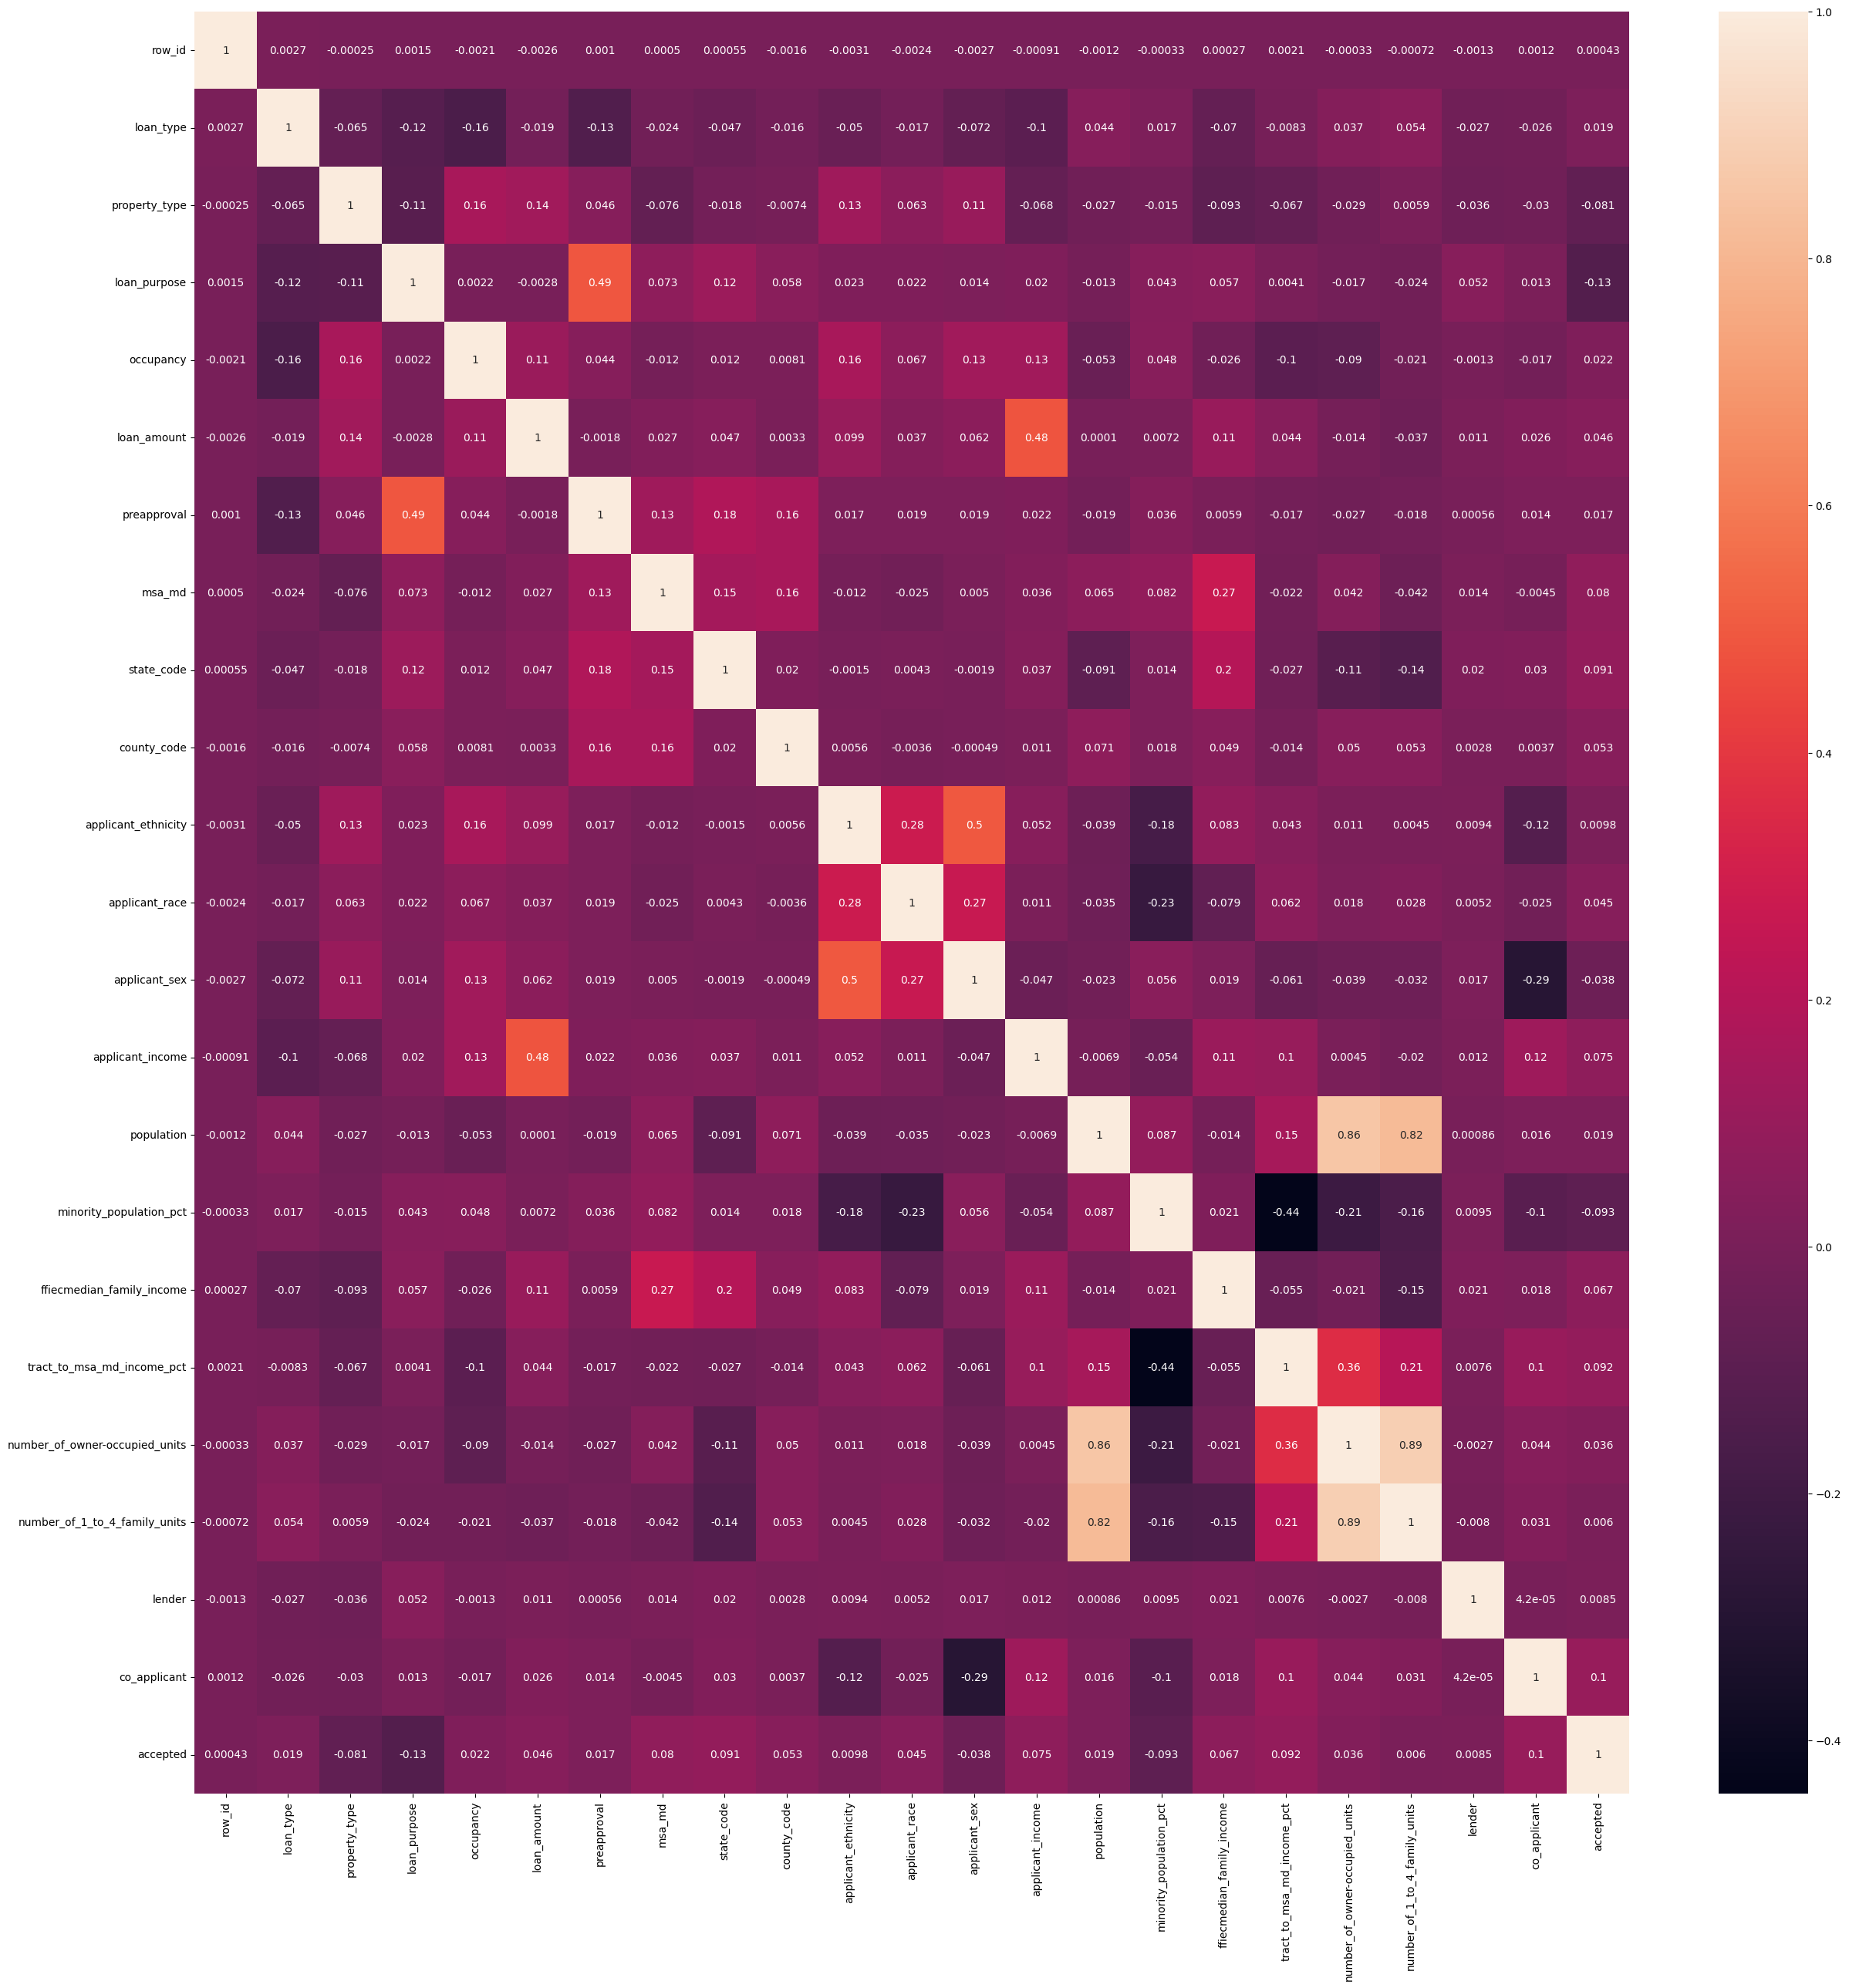

In [ ]:
corr=data.corr()
plt.figure(figsize = (30,30))
sns.heatmap(corr, annot=True)

### Data Description

In [ ]:
data.describe().round()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,...,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,accepted
count,500000.0,500000.0,500000.0,500000.0,500000.0,500000.0,500000.0,500000.0,500000.0,500000.0,...,500000.0,460052.0,477535.0,477534.0,477560.0,477486.0,477435.0,477470.0,500000.0,500000.0
mean,250000.0,1.0,1.0,2.0,1.0,222.0,3.0,182.0,24.0,145.0,...,1.0,102.0,5417.0,32.0,69236.0,92.0,1428.0,1886.0,3720.0,1.0
std,144338.0,1.0,0.0,1.0,0.0,591.0,1.0,138.0,16.0,100.0,...,1.0,154.0,2728.0,26.0,14810.0,14.0,738.0,914.0,1838.0,1.0
min,0.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,...,1.0,1.0,14.0,1.0,17858.0,4.0,4.0,1.0,0.0,0.0
25%,125000.0,1.0,1.0,1.0,1.0,93.0,3.0,25.0,6.0,57.0,...,1.0,47.0,3744.0,11.0,59731.0,88.0,944.0,1301.0,2442.0,0.0
50%,250000.0,1.0,1.0,2.0,1.0,162.0,3.0,192.0,26.0,131.0,...,1.0,74.0,4975.0,23.0,67526.0,100.0,1327.0,1753.0,3731.0,1.0
75%,374999.0,2.0,1.0,3.0,1.0,266.0,3.0,314.0,37.0,246.0,...,2.0,117.0,6467.0,46.0,75351.0,100.0,1780.0,2309.0,5436.0,1.0
max,499999.0,4.0,3.0,3.0,3.0,100878.0,3.0,408.0,52.0,324.0,...,4.0,10139.0,37097.0,100.0,125248.0,100.0,8771.0,13623.0,6508.0,1.0


###  Converting the Bool Type into int

In [ ]:
data['co_applicant'] = data['co_applicant'].astype(int)        # Transform boolean to integer
data.head().style

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
0,0,3,1,1,1,70,3,18,37,246,2,5,1,24.000000,6203.000000,44.230000,60588.000000,50.933000,716.000000,2642.000000,4536,0,1
1,1,1,1,3,1,178,3,369,52,299,1,5,1,57.000000,5774.000000,15.905000,54821.000000,100.000000,1622.000000,2108.000000,2458,0,0
2,2,2,1,3,1,163,3,16,10,306,2,5,1,67.000000,6094.000000,61.270000,67719.000000,100.000000,760.000000,1048.000000,5710,0,1
3,3,1,1,1,1,155,1,305,47,180,2,5,1,105.000000,6667.000000,6.246000,78439.000000,100.000000,2025.000000,2299.000000,5888,1,1
4,4,1,1,1,1,305,3,24,37,20,2,3,2,71.000000,6732.000000,100.000000,63075.000000,82.200000,1464.000000,1847.000000,289,0,1


###  change column name

In [ ]:
data = data.rename(columns={'preapproval': 'preapproval_request'})

### Replace null values with median
### create income/loan amount ratio variable


In [ ]:
# The applicant_income column has some null values which we will replace with the column median
data['applicant_income'] = data['applicant_income'].fillna(data['applicant_income'].median())

data['income_loan_ratio'] = data['applicant_income']/ data['loan_amount']

In [ ]:
print(data.isnull().sum())

row_id                                0
loan_type                             0
property_type                         0
loan_purpose                          0
occupancy                             0
loan_amount                           0
preapproval_request                   0
msa_md                                0
state_code                            0
county_code                           0
applicant_ethnicity                   0
applicant_race                        0
applicant_sex                         0
applicant_income                      0
population                        22465
minority_population_pct           22466
ffiecmedian_family_income         22440
tract_to_msa_md_income_pct        22514
number_of_owner-occupied_units    22565
number_of_1_to_4_family_units     22530
lender                                0
co_applicant                          0
accepted                              0
income_loan_ratio                     0
dtype: int64


Next we examine the census information about the state_code

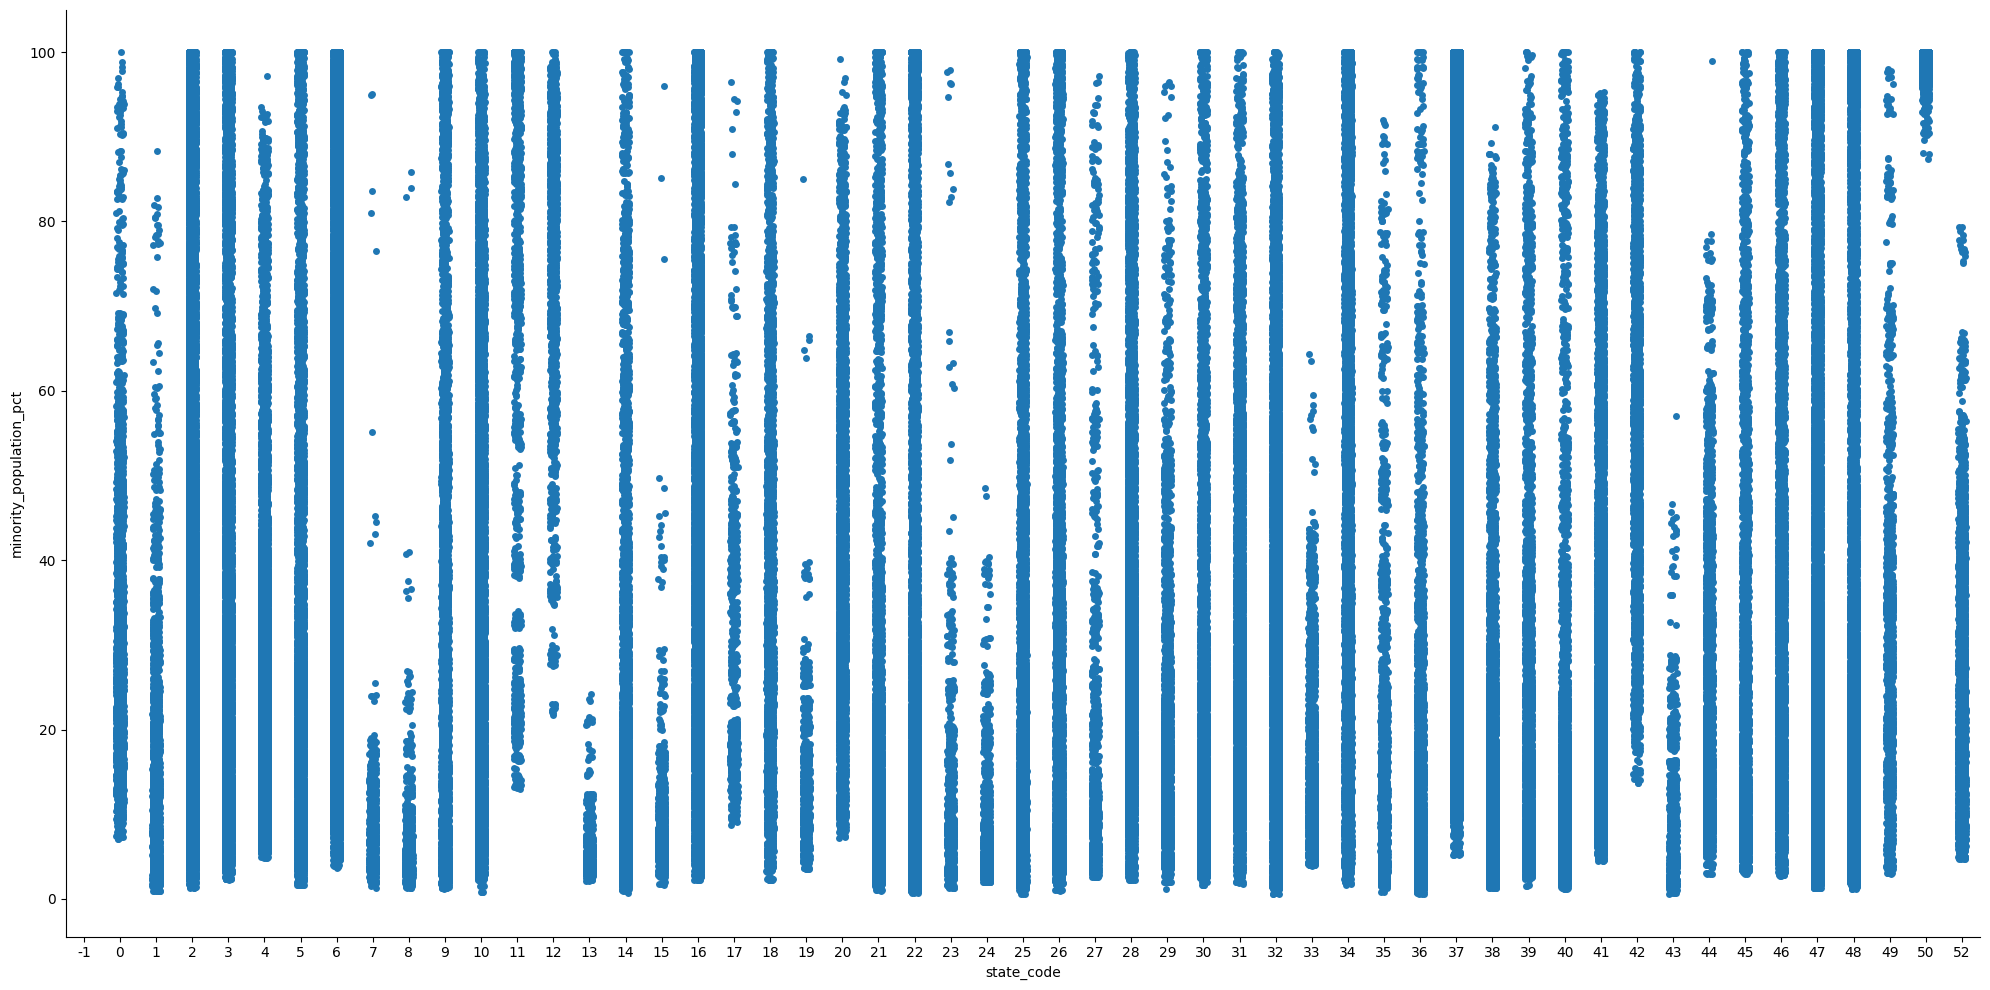

In [ ]:
sns.catplot(data=data, x="state_code", y="minority_population_pct", height=10, aspect=2)

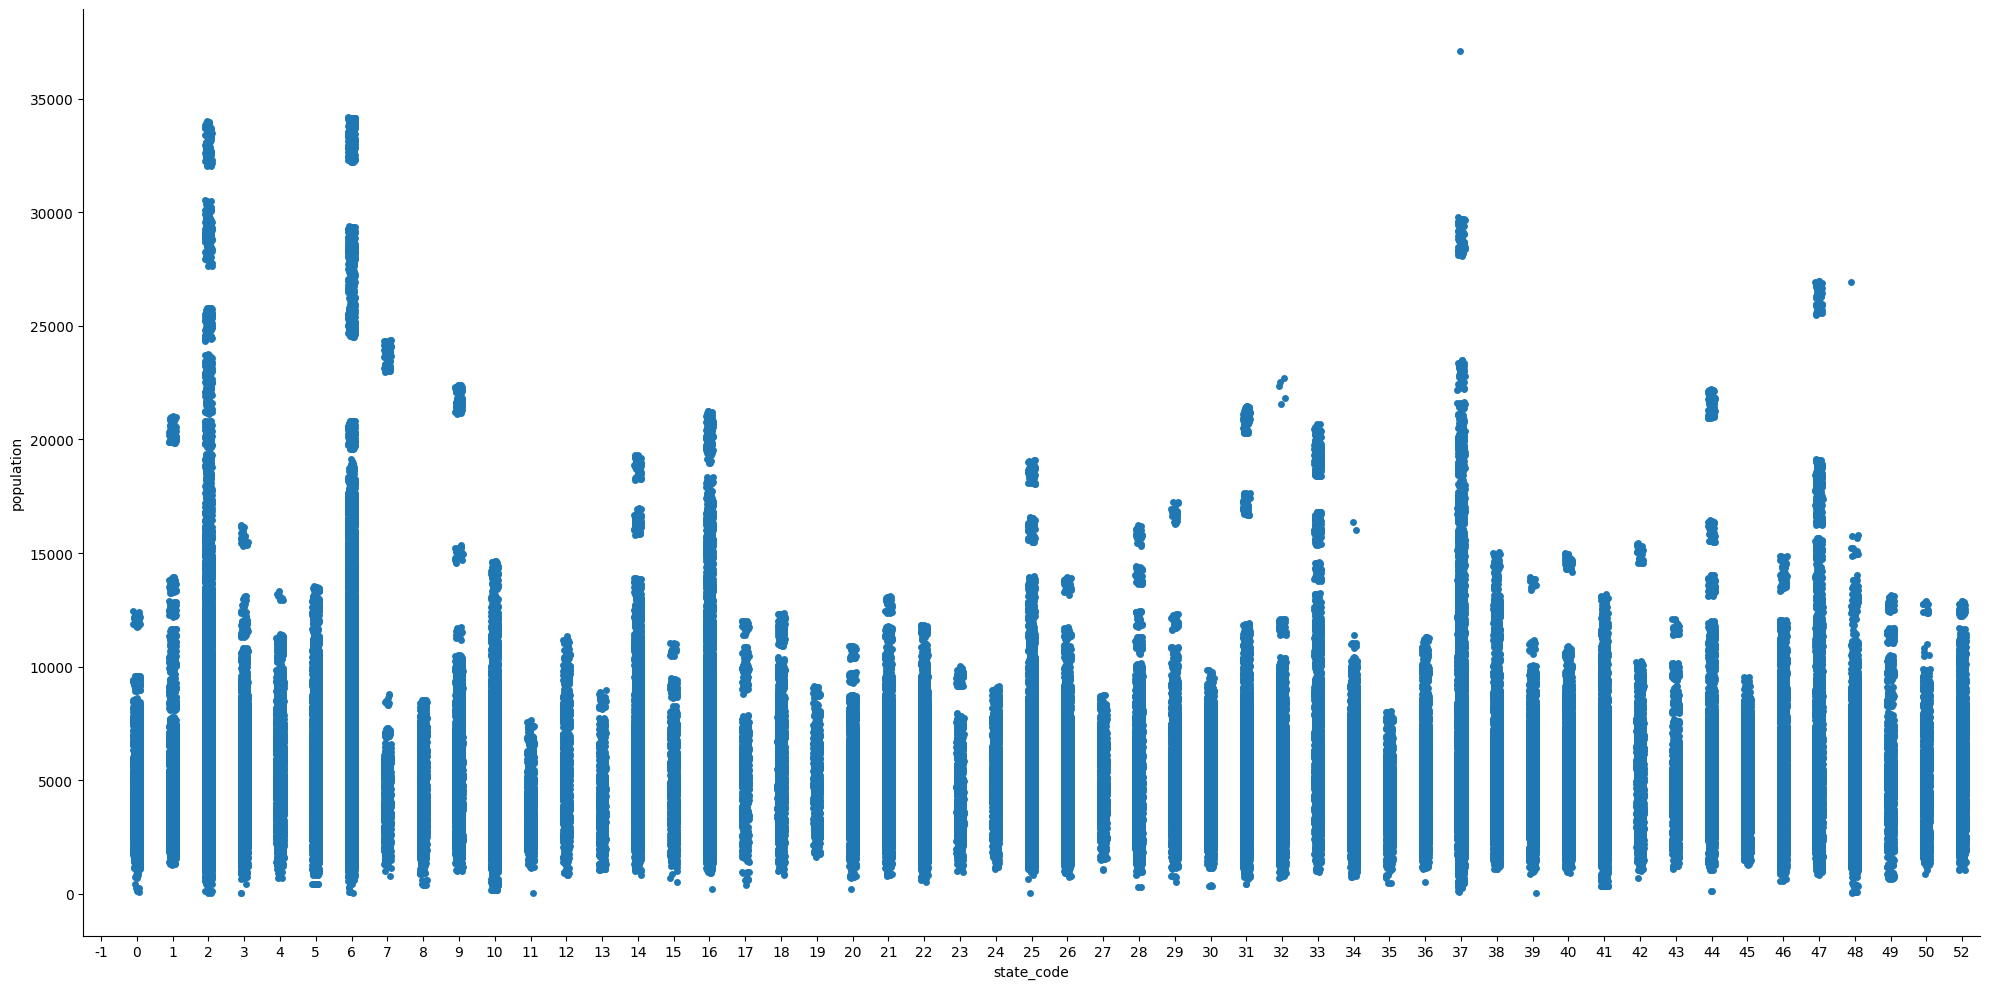

In [ ]:
sns.catplot(data=data, x="state_code", y="population", height=10, aspect=2)

Based on the graphs below, we see that there are no information about 

* `population`
* `minority_population_pct` 
in relation to the missing state_code (-1)

Therefore, we will drop all rows where state_code is missing

In [ ]:
data = data[data.state_code != -1]

In [ ]:
data.shape

(480868, 24)

Then we fill the missing census information with the median value of the state_code group

In [ ]:
dict = data.groupby('state_code')['population'].median().to_dict()

data['population'].fillna(data['state_code'].map(dict), inplace = True)

In [ ]:
dict = data.groupby('state_code')['minority_population_pct'].median().to_dict()

data['minority_population_pct'].fillna(data['state_code'].map(dict), inplace = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480868 entries, 0 to 499999
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          480868 non-null  int64  
 1   loan_type                       480868 non-null  int64  
 2   property_type                   480868 non-null  int64  
 3   loan_purpose                    480868 non-null  int64  
 4   occupancy                       480868 non-null  int64  
 5   loan_amount                     480868 non-null  int64  
 6   preapproval_request             480868 non-null  int64  
 7   msa_md                          480868 non-null  int64  
 8   state_code                      480868 non-null  int64  
 9   county_code                     480868 non-null  int64  
 10  applicant_ethnicity             480868 non-null  int64  
 11  applicant_race                  480868 non-null  int64  
 12  applicant_sex   

----
## 3. Descriptive analytics

### Proportion of accepted and non-accepted cases

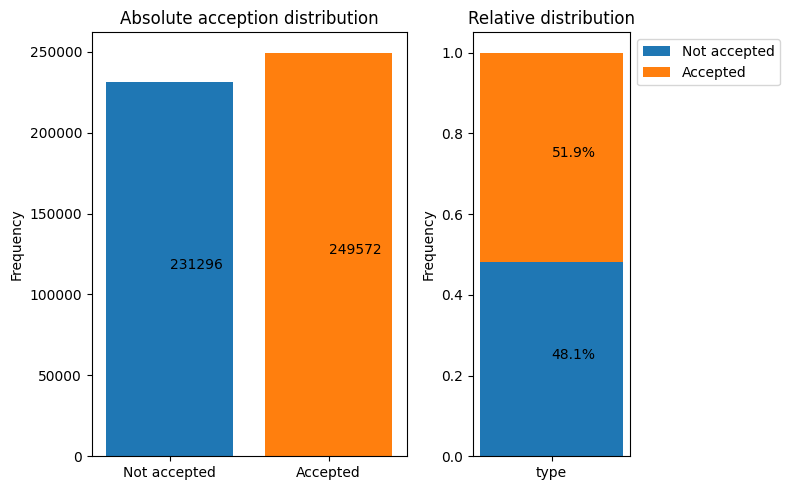

In [ ]:
keys, counts = np.unique(data.accepted, return_counts=True)
counts_norm = counts/counts.sum()
fig = plt.figure(figsize=(8, 5)) #specify figure size
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1]) #specify relative size of left and right plot

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['Not accepted', 'Accepted'], counts, color=['#1f77b4','#ff7f0e']) #left bar plot
ax0 = plt.title('Absolute acception distribution') 
ax0 = plt.ylabel('Frequency')
ax0 = plt.text(keys[0], counts[0]/2, counts[0]) #add text box with count of non-fraudulent cases
ax0 = plt.text(keys[1], counts[1]/2, counts[1]) #add text box with count of fraudulent cases

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['type'], [counts_norm[0]], label='Not accepted')
ax1 = plt.bar(['type'], [counts_norm[1]], bottom=counts_norm[0], label='Accepted')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Relative distribution')
ax1 = plt.ylabel('Frequency')
ax1 = plt.text(['type'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(2)))
ax1 = plt.text(['type'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(2)))

plt.tight_layout()
plt.show()

### Accepted Type By Loan Purpose

/var/folders/6_/32t0th512j792mqtn7dgp1kh0000gn/T/ipykernel_95810/3699437216.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ax2 = data.groupby(['loan_purpose','accepted'])['accepted'].size().groupby(level=0).apply(


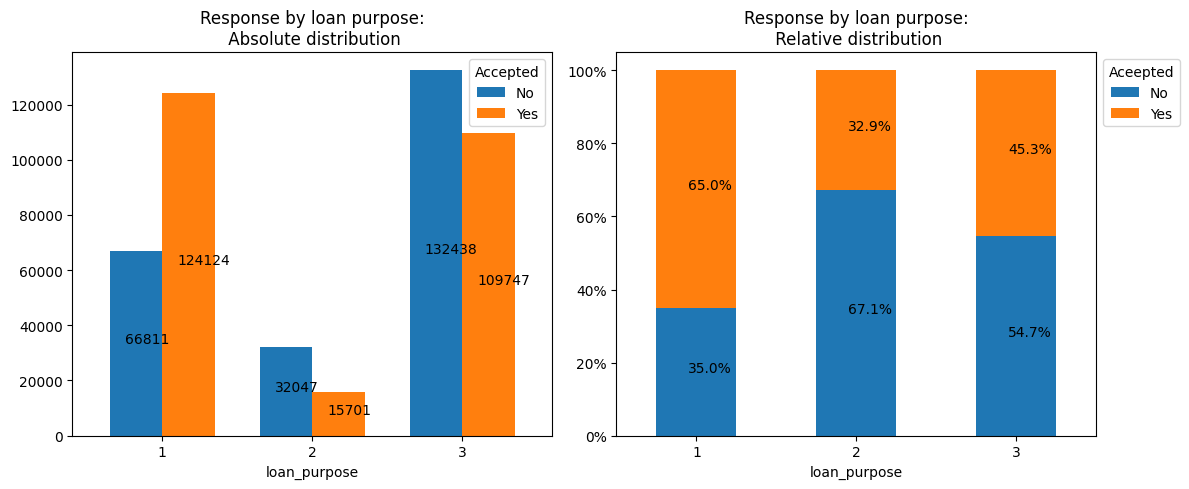

In [ ]:
#Accepted type by Loan Purpose 
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['loan_purpose', 'accepted'])['accepted'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by loan purpose:\n Absolute distribution') 
ax1.legend(["No", "Yes"], title= "Accepted")
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['loan_purpose','accepted'])['accepted'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(["No", "Yes"], title="Aceepted", bbox_to_anchor=(1, 1))
plt.title('Response by loan purpose:\n Relative distribution') 

#plot bar labels
for p, q in zip(ax2.patches[0:3], ax2.patches[3:6]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

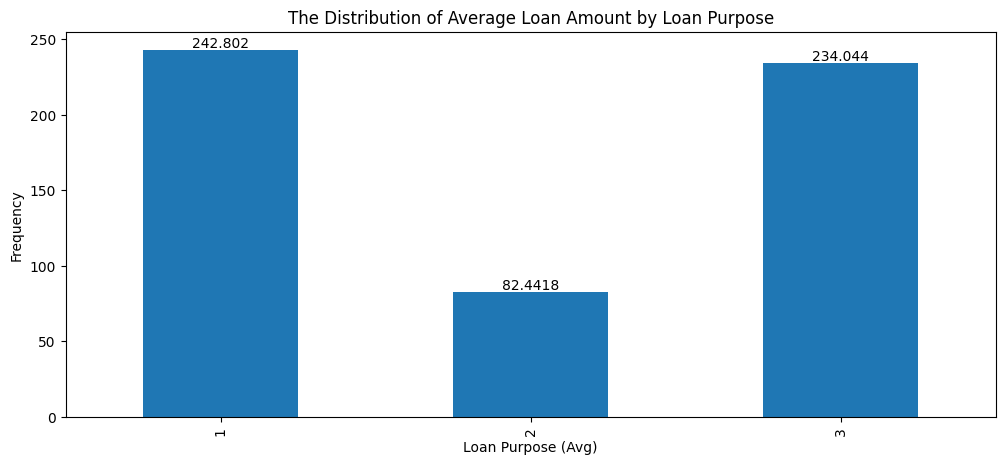

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax=data.groupby('loan_purpose')['loan_amount'].mean().plot.bar()
plt.title("The Distribution of Average Loan Amount by Loan Purpose")
plt.ylabel("Frequency")
plt.xlabel('Loan Purpose (Avg)')
for container in ax.containers:
    ax.bar_label(container)


We observe that the loan purpose of home improvement (2) has the lowest acceptance rate compared to home purchase (1) and refinancing (3). Moreover, home purchase loan purpose has the highest acceptance rate.

### The Distribution of Loan Amount

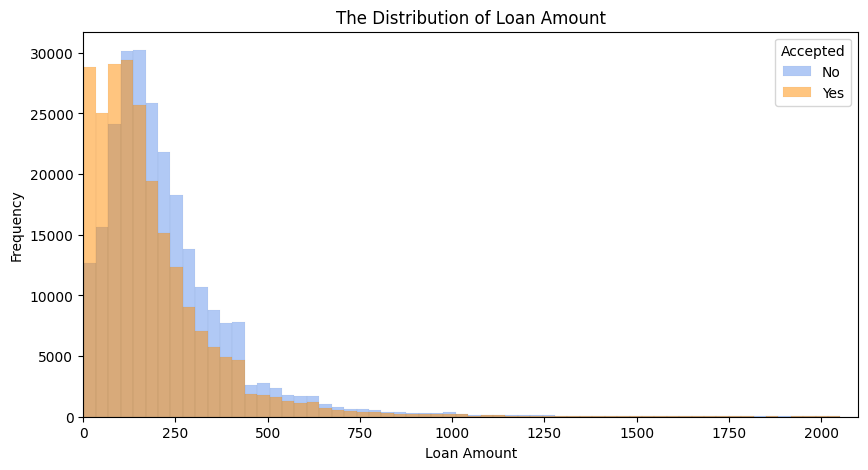

In [ ]:
plt.figure(figsize=(10,5))
df=data[['loan_amount', 'accepted']]
ax=sns.histplot(data=df, x='loan_amount', hue='accepted', bins=3000, palette=["darkorange", "cornflowerblue"])
ax=plt.title("The Distribution of Loan Amount")
ax=plt.xlabel("Loan Amount")
ax=plt.ylabel("Frequency")
plt.xlim(left=0, right=2100)
ax=plt.legend(["No", "Yes"], title="Accepted")
plt.show()

It seems that higher loan amounts get rejected more than lover loan amounts.

From the graph above, we observe that the loan amount feature is highly right skewed. Therefore, the feature needs to be processed before the modelling. https://reinec.medium.com/my-notes-handling-skewed-data-5984de303725

/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  

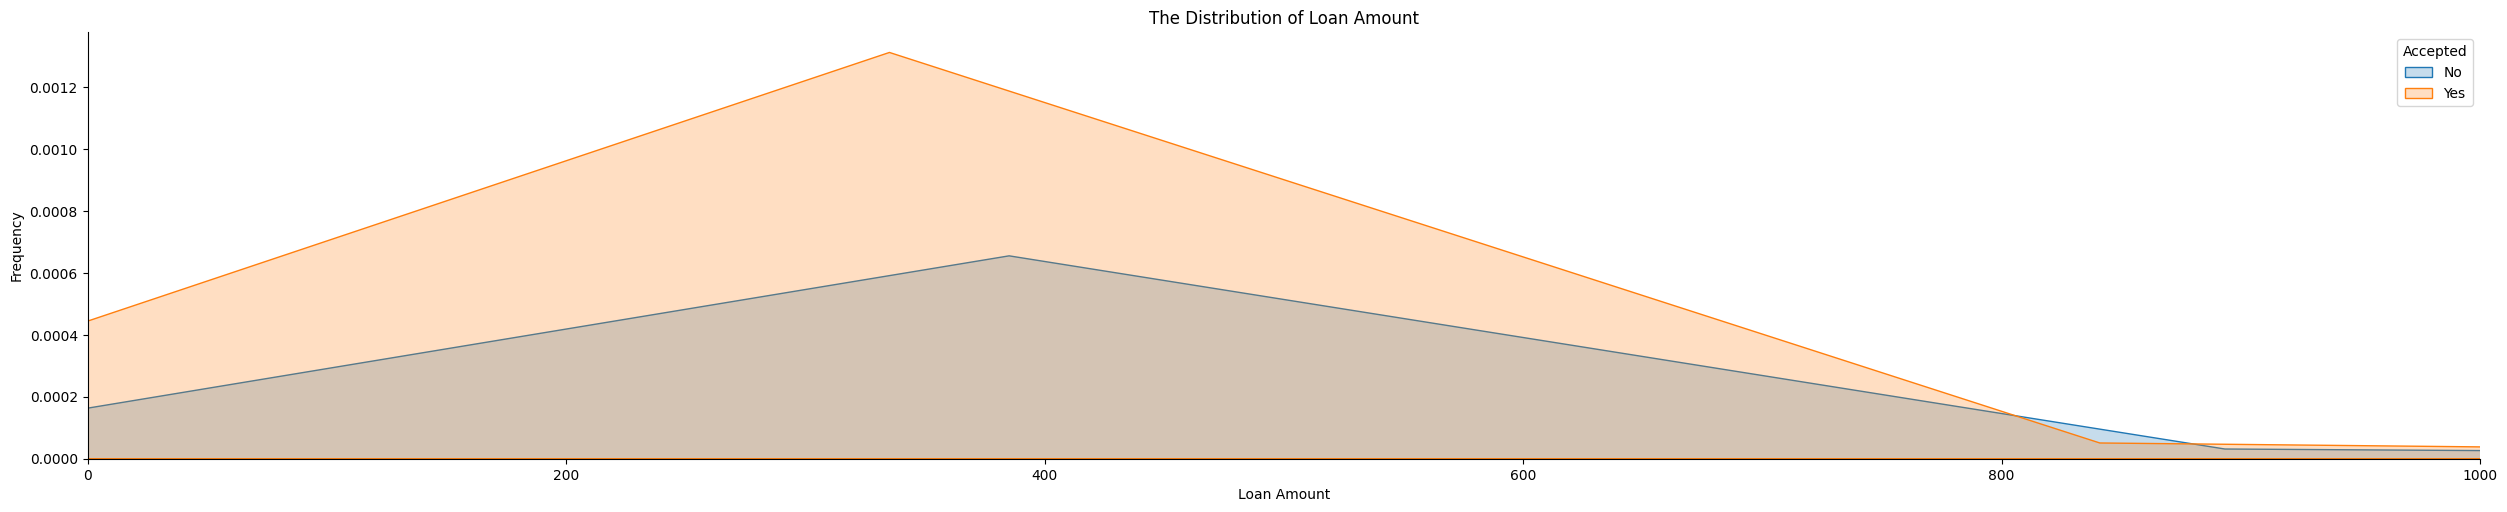

In [ ]:
ax = sns.FacetGrid(data,hue='accepted',height=5, aspect=5)
ax.map(sns.kdeplot,'loan_amount',shade=True)
#ax.set(xlim=(0,data['applicant_income'].max()))
ax=plt.legend(["No", "Yes"], title="Accepted", bbox_to_anchor=(1, 1))
ax=plt.title("The Distribution of Loan Amount")
ax=plt.ylabel("Frequency")
ax=plt.xlabel('Loan Amount')

plt.xlim(0,1000)
plt.show()

From the graph above, we observe that low loan amount have a higher probability of getting accepted. After exceeding the 800$, the probability gets even between getting accepted or rejected.

### The Distribution of Applicant Income

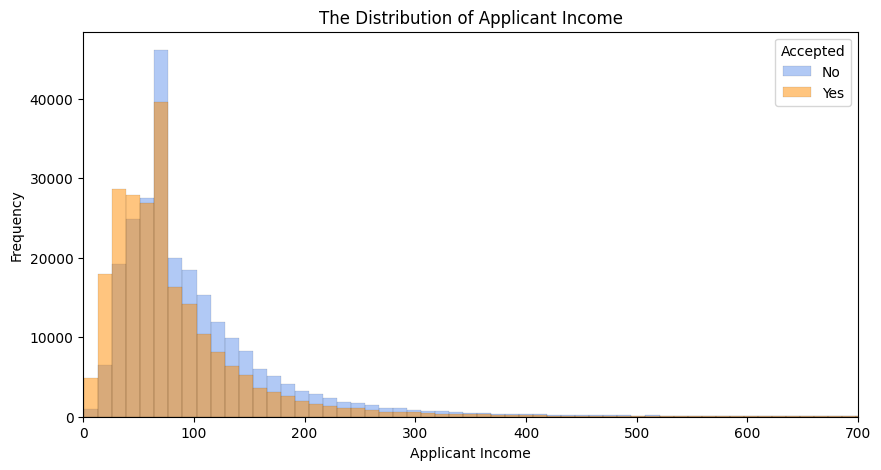

In [ ]:
plt.figure(figsize=(10,5))
df=data[['applicant_income', 'accepted']]
ax=sns.histplot(data=df, x='applicant_income', hue='accepted', bins=800, palette=["darkorange", "cornflowerblue"])
ax=plt.title("The Distribution of Applicant Income")
ax=plt.xlabel("Applicant Income")
ax=plt.ylabel("Frequency")
plt.xlim(left=0, right=700)
ax=plt.legend(["No", "Yes"], title="Accepted")
plt.show()

From the graph above, we observe that the applicant income feature is highly right skewed. Therefore, the feature needs to be processed before the modelling. https://reinec.medium.com/my-notes-handling-skewed-data-5984de303725

/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  

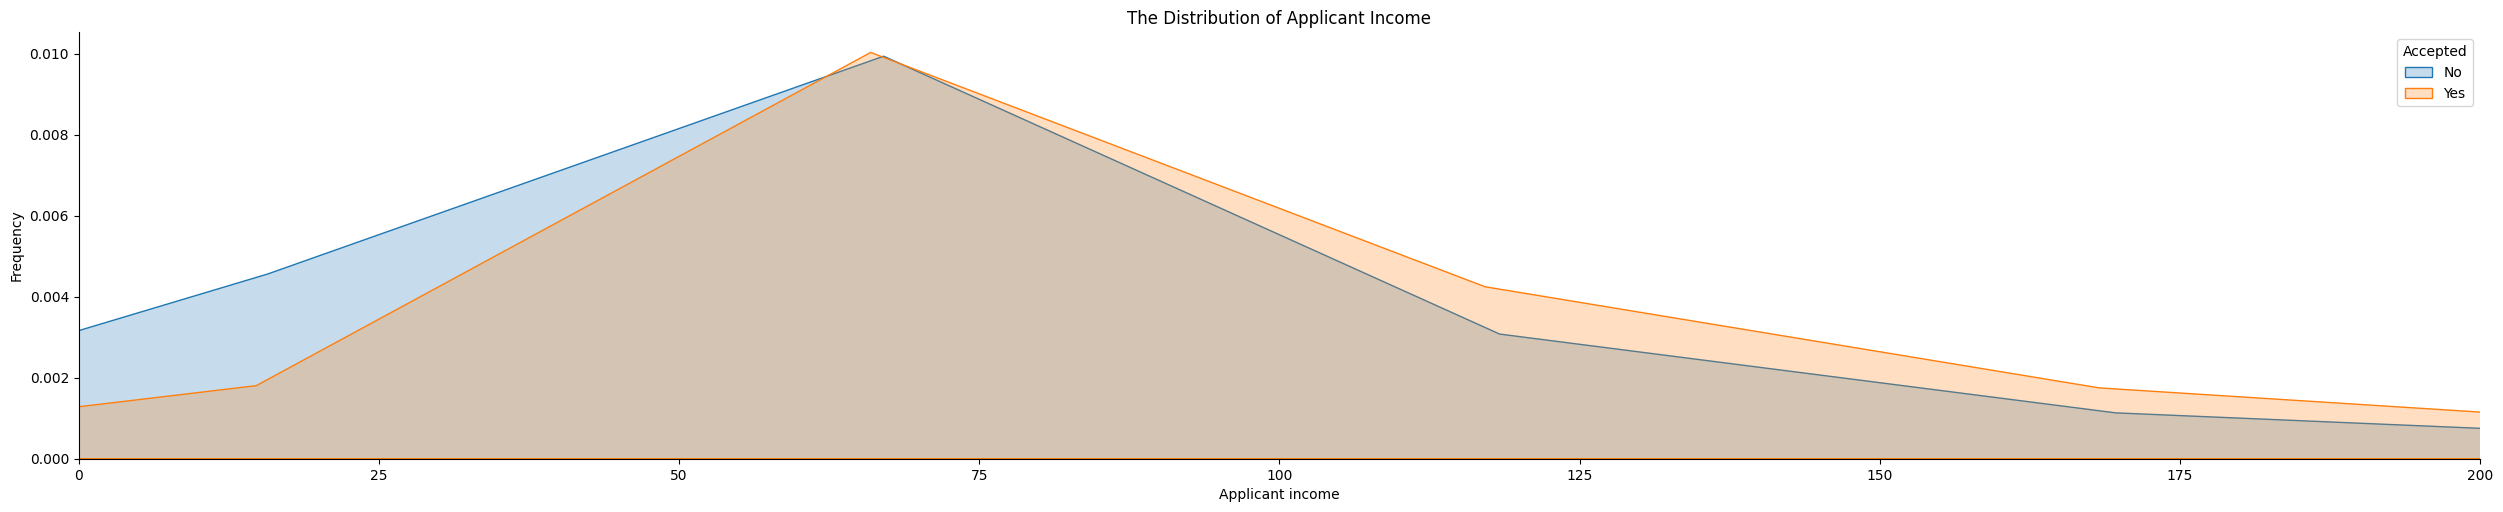

In [ ]:
#income plot
ax = sns.FacetGrid(data,hue='accepted',height=5, aspect=5)
ax.map(sns.kdeplot,'applicant_income',shade=True)
ax=plt.legend(["No", "Yes"], title="Accepted", bbox_to_anchor=(1, 1))
ax=plt.title("The Distribution of Applicant Income")
ax=plt.ylabel("Frequency")
ax=plt.xlabel('Applicant income')

plt.xlim(0,200)
plt.show()

From the graph above, we observe that low applicant income have a higher probability of getting rejected. 

### The distribution of loan amounts in relation to the applican income

From the distribution of loan amounts and the distribution of applicant income, we see that higher loan amounts get rejected more and applicants with higher income get rejected more. Therefore, we create a distribution of loan amounts in relation to the applicant's income.

/var/folders/6_/32t0th512j792mqtn7dgp1kh0000gn/T/ipykernel_95810/1047235450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['relative_loan_amount'] = (df['loan_amount'] / df['applicant_income'])


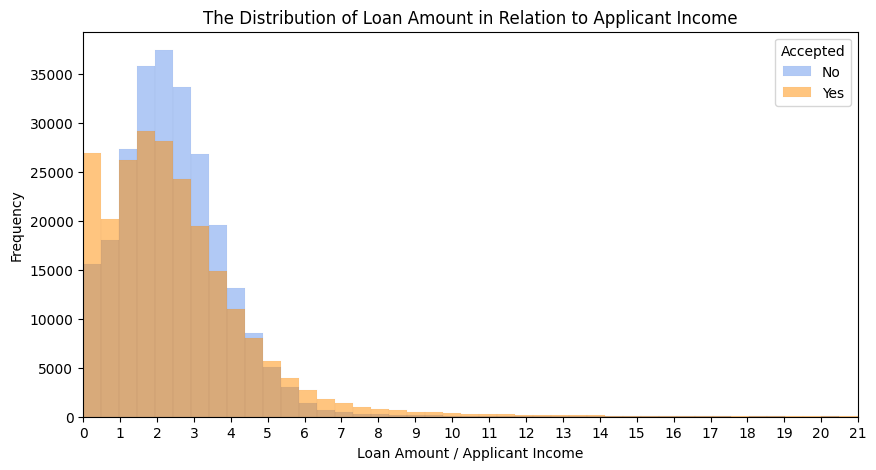

In [ ]:
plt.figure(figsize=(10,5))


# Creating a dataframe with relative loan amount
df=data[['loan_amount', 'applicant_income', 'accepted']]
df['relative_loan_amount'] = (df['loan_amount'] / df['applicant_income'])

ax=sns.histplot(data=df, x='relative_loan_amount', hue='accepted', bins = 4000, palette=["darkorange", "cornflowerblue"])
ax=plt.title("The Distribution of Loan Amount in Relation to Applicant Income")
ax=plt.xlabel("Loan Amount / Applicant Income")
ax=plt.ylabel("Frequency")
plt.xlim(left=0, right=21)
ax=plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
ax=plt.legend(["No", "Yes"], title="Accepted")
plt.show()

From the distribution of loan amount in relation to the applicant income, we see that, on average, loan amounts that are higher than the applicant’s yearly income get rejected more

### Property Type

/var/folders/6_/32t0th512j792mqtn7dgp1kh0000gn/T/ipykernel_95810/3101039893.py:20: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ax2 = data.groupby(['property_type','accepted'])['accepted'].size().groupby(level=0).apply(


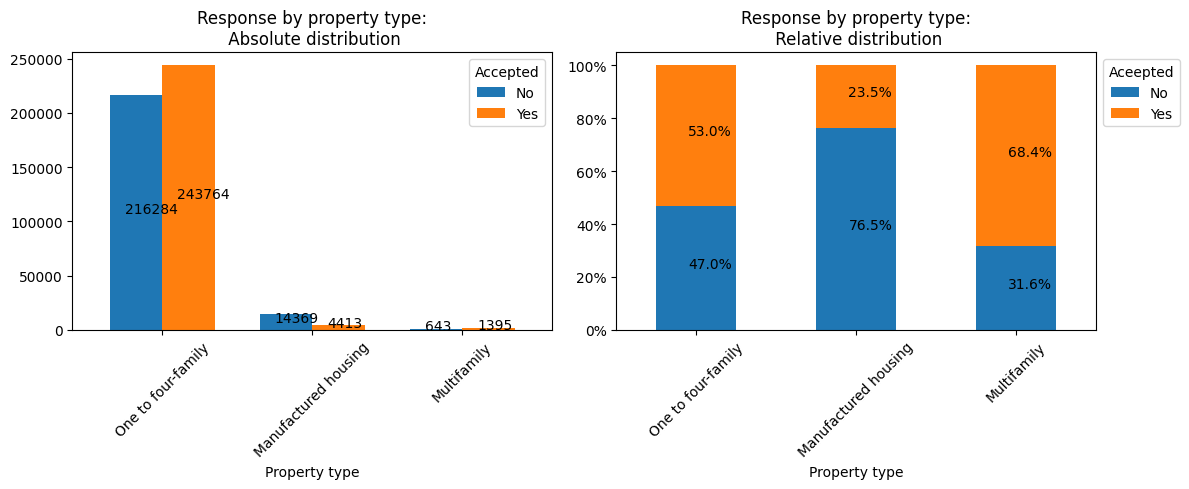

In [ ]:
#Accepted type by Property Type 
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Property types
property_types = ['One to four-family', 'Manufactured housing', 'Multifamily']

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['property_type', 'accepted'])['accepted'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by property type:\n Absolute distribution') 
ax1.legend(["No", "Yes"], title= "Accepted")
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))
plt.xlabel('Property type')
ax1.set_xticklabels(property_types, rotation = 45)

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['property_type','accepted'])['accepted'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(["No", "Yes"], title="Aceepted", bbox_to_anchor=(1, 1))
plt.title('Response by property type:\n Relative distribution') 
plt.xlabel('Property type')
ax2.set_xticklabels(property_types, rotation = 45)

#plot bar labels
for p, q in zip(ax2.patches[0:3], ax2.patches[3:6]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

The abobe graph shows us that there are a lot 1-5 family housing types. 

### Occupancy

/var/folders/6_/32t0th512j792mqtn7dgp1kh0000gn/T/ipykernel_95810/2204362107.py:20: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ax2 = data.groupby(['occupancy','accepted'])['accepted'].size().groupby(level=0).apply(


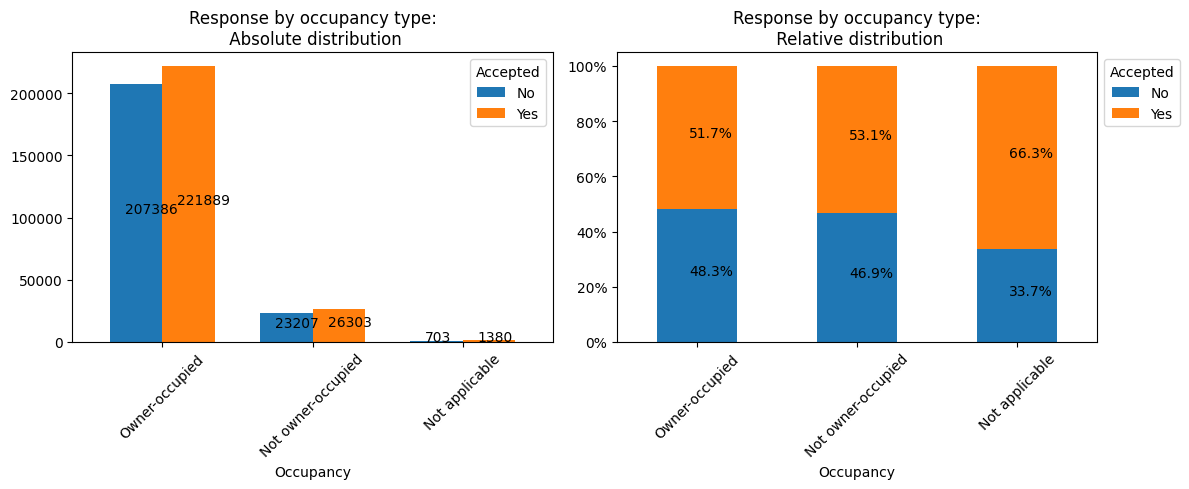

In [ ]:
#Accepted type by Occupancy 
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Occupancies
occupancy = ['Owner-occupied', 'Not owner-occupied', 'Not applicable']

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['occupancy', 'accepted'])['accepted'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by occupancy type:\n Absolute distribution') 
ax1.legend(["No", "Yes"], title= "Accepted")
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))
plt.xlabel('Occupancy')
ax1.set_xticklabels(occupancy, rotation = 45)

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['occupancy','accepted'])['accepted'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(["No", "Yes"], title="Accepted", bbox_to_anchor=(1, 1))
plt.title('Response by occupancy type:\n Relative distribution')
plt.xlabel('Occupancy')
ax2.set_xticklabels(occupancy, rotation = 45)

#plot bar labels
for p, q in zip(ax2.patches[0:3], ax2.patches[3:6]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

We observe a rather even relative distribution, however, occupancy of a principal dwelling is the most frequent occupancy type.

### Applicant ethnicity and race

/var/folders/6_/32t0th512j792mqtn7dgp1kh0000gn/T/ipykernel_95810/3315107383.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ax2 = data.groupby(['applicant_ethnicity','accepted'])['accepted'].size().groupby(level=0).apply(


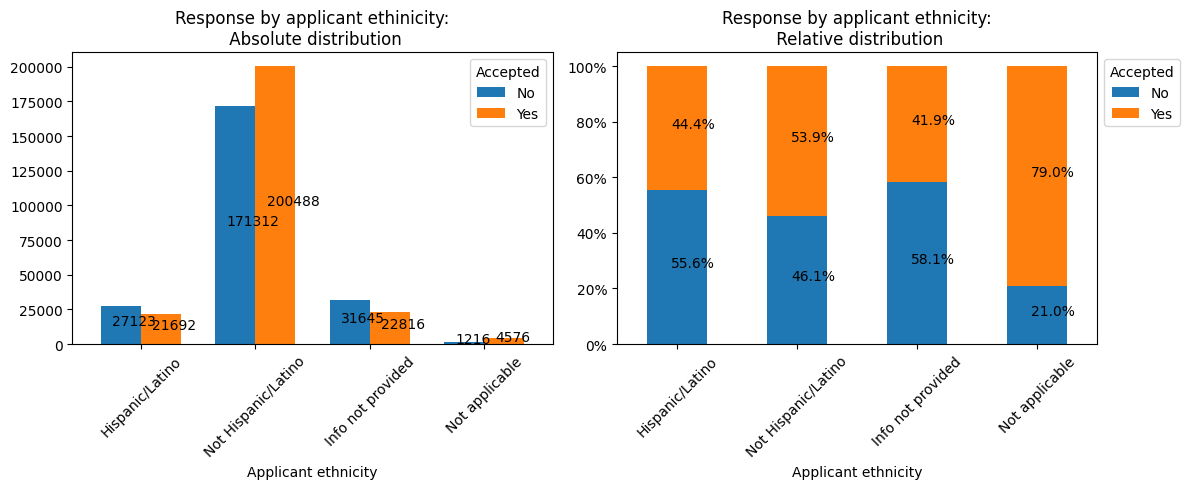

In [ ]:
#Accepted type by applicant ethnicity 
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Ethnicities
ethnicity = ['Hispanic/Latino', 'Not Hispanic/Latino', 'Info not provided', 'Not applicable']

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['applicant_ethnicity', 'accepted'])['accepted'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by applicant ethinicity:\n Absolute distribution') 
ax1.legend(["No", "Yes"], title= "Accepted")
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))
plt.xlabel('Applicant ethnicity')
ax1.set_xticklabels(ethnicity, rotation = 45)


#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['applicant_ethnicity','accepted'])['accepted'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(["No", "Yes"], title="Accepted", bbox_to_anchor=(1, 1))
plt.title('Response by applicant ethnicity:\n Relative distribution') 
plt.xlabel('Applicant ethnicity')
ax2.set_xticklabels(ethnicity, rotation = 45)

#plot bar labels
for p, q in zip(ax2.patches[0:4], ax2.patches[4:8]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

/var/folders/6_/32t0th512j792mqtn7dgp1kh0000gn/T/ipykernel_95810/492440350.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ax2 = data.groupby(['applicant_race', 'accepted'])['accepted'].size().groupby(level=0).apply(


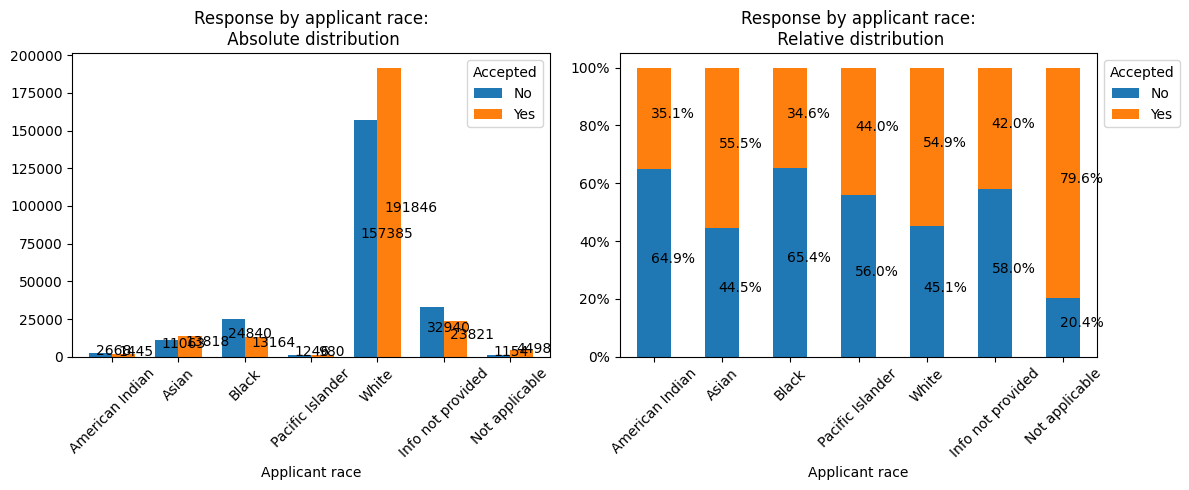

In [ ]:
#Accepted type by applicant race 
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Races
races = ['American Indian', 'Asian', 'Black', 'Pacific Islander', 'White', 'Info not provided', 'Not applicable']

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['applicant_race', 'accepted'])['accepted'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by applicant race:\n Absolute distribution') 
ax1.legend(["No", "Yes"], title= "Accepted")
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))
plt.xlabel('Applicant race')
ax1.set_xticklabels(races, rotation = 45)


#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['applicant_race', 'accepted'])['accepted'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(["No", "Yes"], title="Accepted", bbox_to_anchor=(1, 1))
plt.title('Response by applicant race:\n Relative distribution')
plt.xlabel('Applicant race')
ax2.set_xticklabels(races, rotation = 45)

#plot bar labels
for p, q in zip(ax2.patches[0:7], ax2.patches[7:14]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

We observe that black or african american as well as american indian applicants have a higher probability of getting their loan applications rejected.

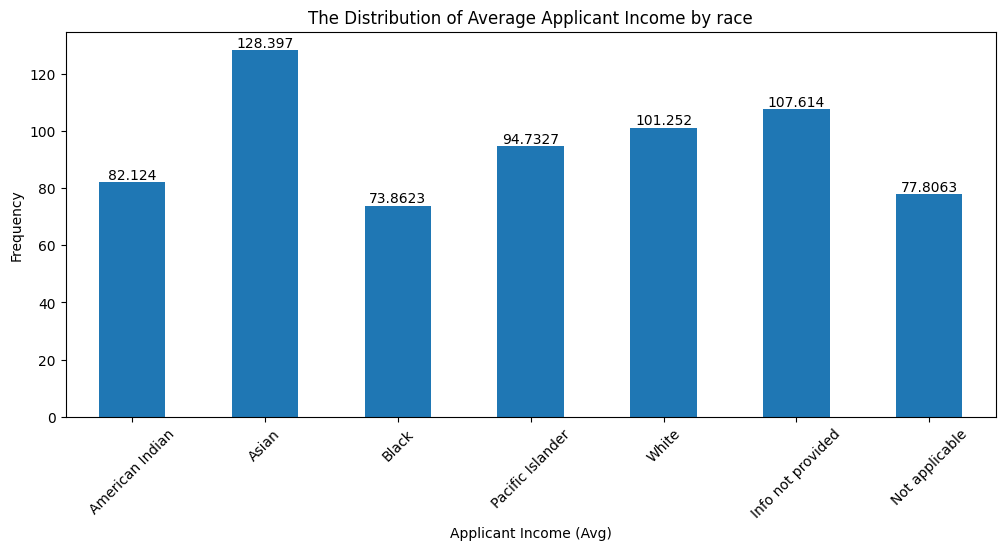

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax=data.groupby('applicant_race')['applicant_income'].mean().plot.bar()
plt.title("The Distribution of Average Applicant Income by race")
plt.ylabel("Frequency")
plt.xlabel('Applicant Income (Avg)')
ax.set_xticklabels(races, rotation = 45)

for container in ax.containers:
    ax.bar_label(container)

In [ ]:
data.groupby("applicant_race")[["applicant_income", "loan_amount"]].mean()

,applicant_income,loan_amount
applicant_race,,
1,82.123997,159.199125
2,128.396688,323.624332
3,73.862330,155.126855
4,94.732704,238.613657
5,101.251779,205.091744
6,107.614101,222.177287
7,77.806263,1346.227530


We observe that on average, the ones who have a higher probability of getting their loan applications rejected have a lower average income. 

### Applicant sex 

In [ ]:
freq_per=data['applicant_sex'].value_counts(normalize=True) * 100
sex = ['Male', 'Female', 'Info not provided', 'Not applicable']
freq_per.index = sex
print(freq_per.map("{:,.2f}%".format))

Male                 63.30%
Female               28.47%
Info not provided     7.05%
Not applicable        1.18%
Name: applicant_sex, dtype: object


Most of the applicants are male (63%)

### Accepted Type by Co-applicant

/var/folders/6_/32t0th512j792mqtn7dgp1kh0000gn/T/ipykernel_95810/1335317952.py:17: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ax2 = data.groupby(['co_applicant','accepted'])['accepted'].size().groupby(level=0).apply(


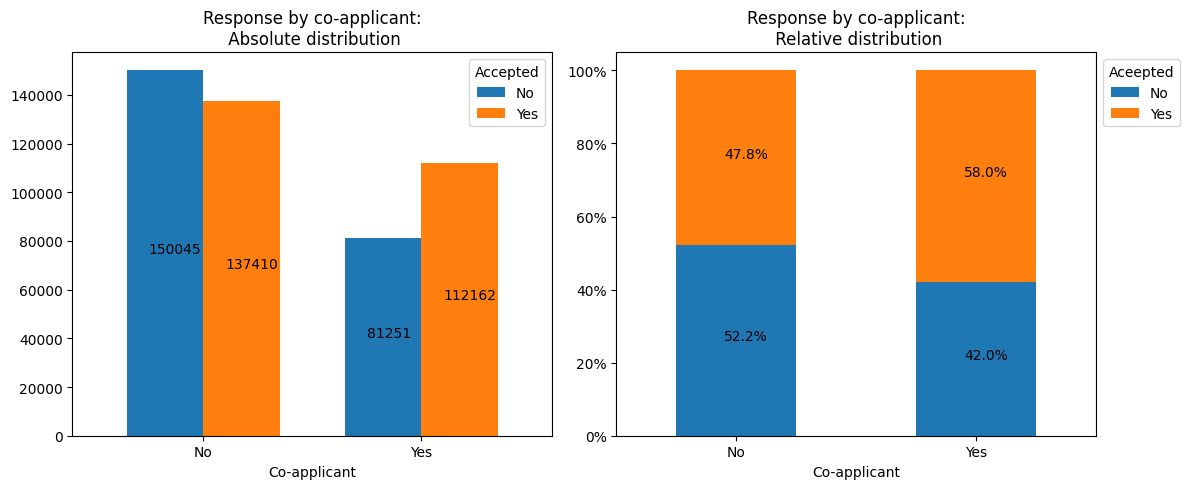

In [ ]:
#Accepted type by Co-applicant  
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['co_applicant', 'accepted'])['accepted'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by co-applicant:\n Absolute distribution') 
ax1.legend(["No", "Yes"], title= "Accepted")
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))
ax1.set_xticklabels(['No', 'Yes'])
ax1.set_xlabel('Co-applicant')

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['co_applicant','accepted'])['accepted'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(["No", "Yes"], title="Aceepted", bbox_to_anchor=(1, 1))
plt.title('Response by co-applicant:\n Relative distribution') 
ax2.set_xticklabels(['No', 'Yes'])
ax2.set_xlabel('Co-applicant')

#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

We observe that those who do not have a co-applicant have a lower probability of getting their loan applicaitons accepted.

-----
## 3. Data Preprocessing

### Drop Feature 


We got rid of some irrelevant columns: 
- msa_md and county_code which indicates property location (we keep only the state_code information)
- lenders as we don't have background information and too many variables  
- ffiecmedian_family_income and tract_to_msa_md_income_pct because they're related to msa_md
- row_id, applicant sex, ethnicity, race 
- number_of_1_to_4_family_units and number_of_owner-occupied_units are highly correlated with the population

In [ ]:
data = data.drop(['row_id', 'msa_md', 'ffiecmedian_family_income', 'tract_to_msa_md_income_pct', 'lender', 
                  'county_code','number_of_1_to_4_family_units', 'number_of_owner-occupied_units', 'applicant_sex',
                 'applicant_ethnicity', 'applicant_race'], axis=1)

### Feature Selection

In [ ]:
X, y = data.loc[:, data.columns != 'accepted'], data['accepted']
X.head(10)

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval_request,state_code,applicant_income,population,minority_population_pct,co_applicant,income_loan_ratio
0,3,1,1,1,70,3,37,24.0,6203.0,44.230,0,0.342857
1,1,1,3,1,178,3,52,57.0,5774.0,15.905,0,0.320225
2,2,1,3,1,163,3,10,67.0,6094.0,61.270,0,0.411043
3,1,1,1,1,155,1,47,105.0,6667.0,6.246,1,0.677419
4,1,1,1,1,305,3,37,71.0,6732.0,100.000,0,0.232787
5,1,1,3,1,133,3,13,51.0,6078.0,4.821,0,0.383459
6,3,1,1,1,240,3,28,104.0,6068.0,26.427,0,0.433333
7,2,1,1,1,210,3,37,55.0,6030.0,78.153,1,0.261905
8,1,1,3,2,209,3,37,244.0,5151.0,88.156,1,1.167464
9,1,1,3,1,197,3,9,86.0,7916.0,24.893,0,0.436548


### One-hot-encoding

We turn these categorical variables into dummy variables
* `loan_type`
* `property_type`
* `loan_purpose`
* `occupancy`
* `preapproval`
* `state_code`



In [ ]:
X = pd.get_dummies(X, columns=["loan_type", "property_type", "loan_purpose", 
                               "occupancy", "preapproval_request", "state_code"], prefix=["loan_type", "property_type", "loan_purpose", 
                               "occupancy", "preapproval_request", "state_code"], drop_first=True)
X.head()

,loan_amount,applicant_income,population,minority_population_pct,co_applicant,income_loan_ratio,loan_type_2,loan_type_3,loan_type_4,property_type_2,...,state_code_42,state_code_43,state_code_44,state_code_45,state_code_46,state_code_47,state_code_48,state_code_49,state_code_50,state_code_52
0,70,24.0,6203.0,44.230,0,0.342857,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,178,57.0,5774.0,15.905,0,0.320225,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,163,67.0,6094.0,61.270,0,0.411043,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,155,105.0,6667.0,6.246,1,0.677419,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,305,71.0,6732.0,100.000,0,0.232787,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480868 entries, 0 to 499999
Data columns (total 68 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   loan_amount              480868 non-null  int64  
 1   applicant_income         480868 non-null  float64
 2   population               480868 non-null  float64
 3   minority_population_pct  480868 non-null  float64
 4   co_applicant             480868 non-null  int64  
 5   income_loan_ratio        480868 non-null  float64
 6   loan_type_2              480868 non-null  uint8  
 7   loan_type_3              480868 non-null  uint8  
 8   loan_type_4              480868 non-null  uint8  
 9   property_type_2          480868 non-null  uint8  
 10  property_type_3          480868 non-null  uint8  
 11  loan_purpose_2           480868 non-null  uint8  
 12  loan_purpose_3           480868 non-null  uint8  
 13  occupancy_2              480868 non-null  uint8  
 14  occu

We split the data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345) #split data 70:30

We visualize the split to ensure that the distribution of accepted and not accepted applications remain the same.

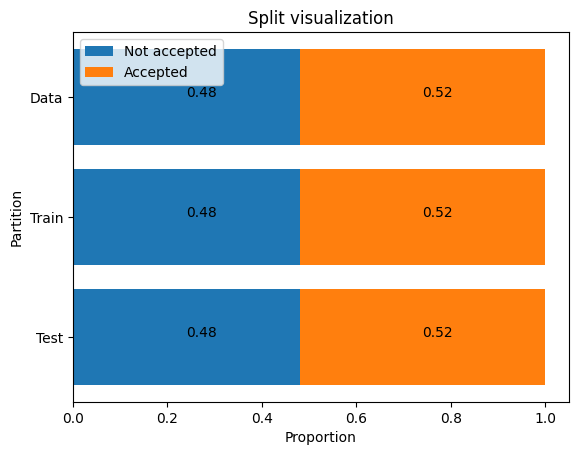

In [ ]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)

fig, ax = plt.subplots()

ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='Not accepted')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='Accepted')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
ax.set_xlabel('Proportion')
ax.set_ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

The distribution of accepted and not accepted applications is equal to the whole data set. It is also balanced so we do not have to balance the data. 

----
## 4. Model building

### a) Decision tree

We fit the classifier to the data. 

In [ ]:
#Define Decision tree classifier with some default parameters
dt = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3)

#Fit the training data 
dt.fit(X_train, y_train) 

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=100)

We make predictions by using the unseen test data X_test.

In [ ]:
#Use classifier to predict labels
y_pred_dt = dt.predict(X_test)

#Probabilities for decision tree
y_pred_proba_dt = dt.predict_proba(X_test)


#Decision tree plot
import pydotplus
from IPython.display import Image 

# Create DOT data
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=X_train.columns, 
                                class_names=['Not accept', 'Accept'], filled=True) #or use y_train.unique()

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

print ("Accuracy is: ", (accuracy_score(y_test, y_pred_dt)*100).round(2))


Accuracy is:  61.58


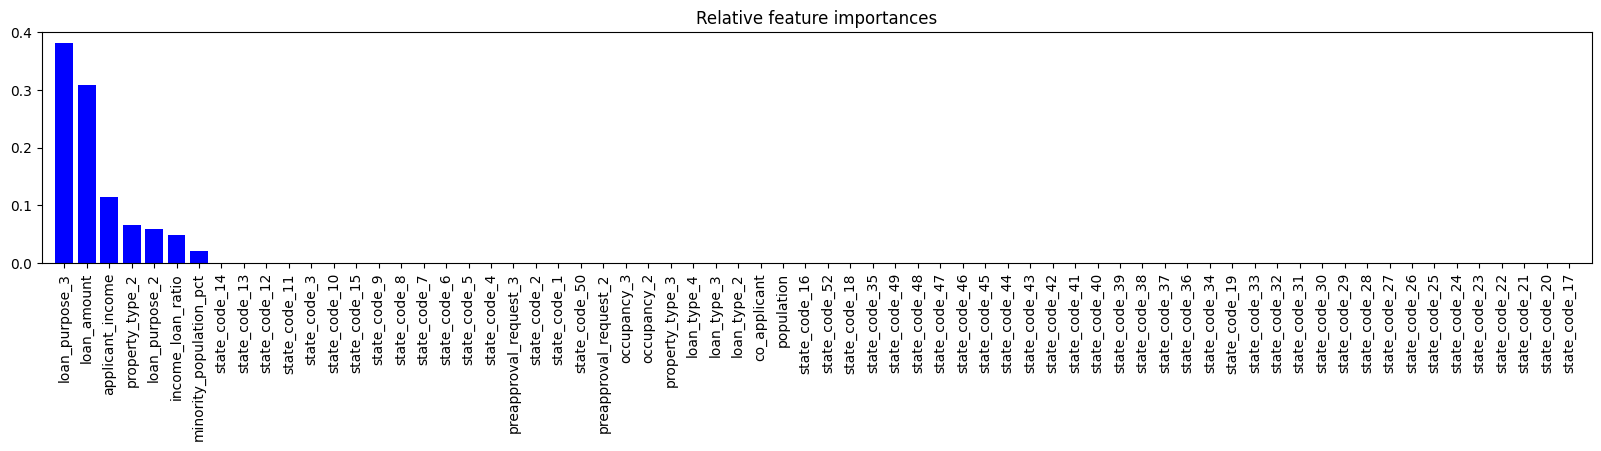

In [ ]:
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

plt.rcParams["figure.figsize"] = (20,3)
plt.figure
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

 ### b) Logistic Regression


In [ ]:
#define Logistic Regression classifier
lg = LogisticRegression(max_iter = 1000)

#Fit the training data 
lr =lg.fit(X_train, y_train)  

#Use classifier to predict labels
y_pred_lr = lr.predict(X_test)

#Probabilities for logistic regression
y_pred_proba_lr = lr.predict_proba(X_test)

print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr)*100).round(2))


Accuracy is:  63.2


#c) Light GBM

In [ ]:
#import lightgbm as ltb

In [ ]:
#lightgbm = ltb.LGBMClassifier()

In [ ]:
#light =lightgbm.fit(X_train, y_train)  

#Use classifier to predict labels
#y_pred_light = light.predict(X_test)

#Probabilities for logistic regression
#y_pred_proba_light = light.predict_proba(X_test)

#print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr)*100).round(2))


### c) Random forest

In [ ]:
rf=RandomForestClassifier(max_depth = 3, random_state =100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_rf)*100).round(2))

Accuracy is:  62.08


### d) XGBoost

In [ ]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(X_train, y_train)
y_pred_xg = xg.predict(X_test)

#Probabilities for logistic regression
y_pred_proba_xg = xg.predict_proba(X_test)

print ("Accuracy is: ", (accuracy_score(y_test, y_pred_xg)*100).round(2))

Accuracy is:  66.4


### e) CatBoost

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)

#Probabilities for logistic regression
y_pred_proba_cat = cat.predict_proba(X_test)

print ("Accuracy is: ", (accuracy_score(y_test, y_pred_cat)*100).round(2))

Learning rate set to 0.123599


/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.6794335	total: 77.8ms	remaining: 1m 17s
1:	learn: 0.6690421	total: 93ms	remaining: 46.4s
2:	learn: 0.6608852	total: 109ms	remaining: 36.2s
3:	learn: 0.6546914	total: 126ms	remaining: 31.3s
4:	learn: 0.6500086	total: 140ms	remaining: 27.8s
5:	learn: 0.6459696	total: 153ms	remaining: 25.3s
6:	learn: 0.6427371	total: 167ms	remaining: 23.8s
7:	learn: 0.6401531	total: 180ms	remaining: 22.3s
8:	learn: 0.6378746	total: 209ms	remaining: 23s
9:	learn: 0.6361351	total: 223ms	remaining: 22.1s
10:	learn: 0.6345424	total: 237ms	remaining: 21.3s
11:	learn: 0.6332777	total: 254ms	remaining: 20.9s
12:	learn: 0.6322709	total: 271ms	remaining: 20.6s
13:	learn: 0.6312833	total: 289ms	remaining: 20.3s
14:	learn: 0.6306581	total: 305ms	remaining: 20s
15:	learn: 0.6300439	total: 319ms	remaining: 19.6s
16:	learn: 0.6295334	total: 337ms	remaining: 19.5s
17:	learn: 0.6290049	total: 356ms	remaining: 19.4s
18:	learn: 0.6282326	total: 373ms	remaining: 19.2s
19:	learn: 0.6277648	total: 401ms	remaining:

## 5. Model evaluation

### a) Confusion matrix

Confusion matrix, without normalization
[[35527 33881]
 [21545 53308]]
Normalized confusion matrix
[[0.51 0.49]
 [0.29 0.71]]


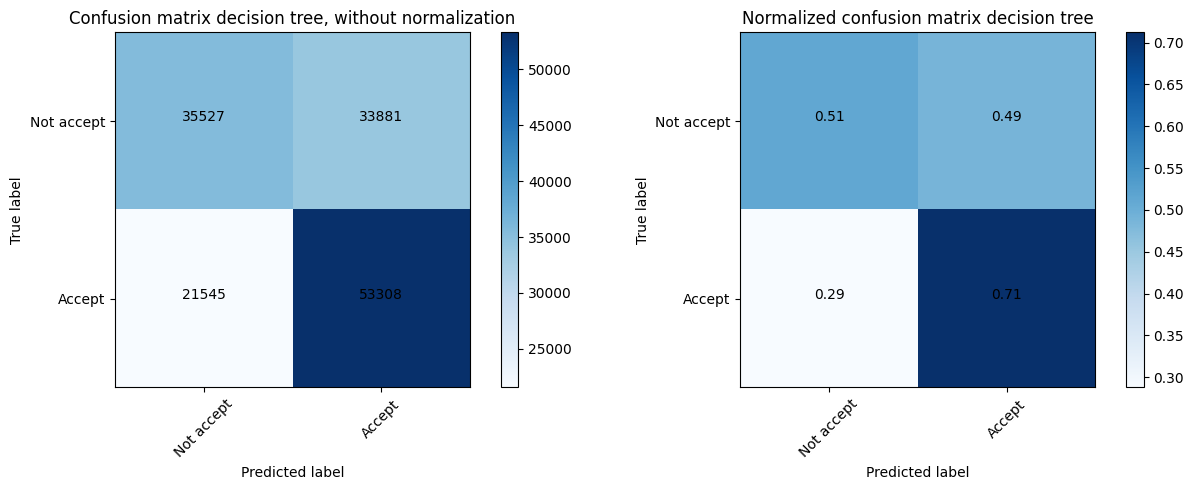

Confusion matrix, without normalization
[[43359 26049]
 [27037 47816]]
Normalized confusion matrix
[[0.62 0.38]
 [0.36 0.64]]


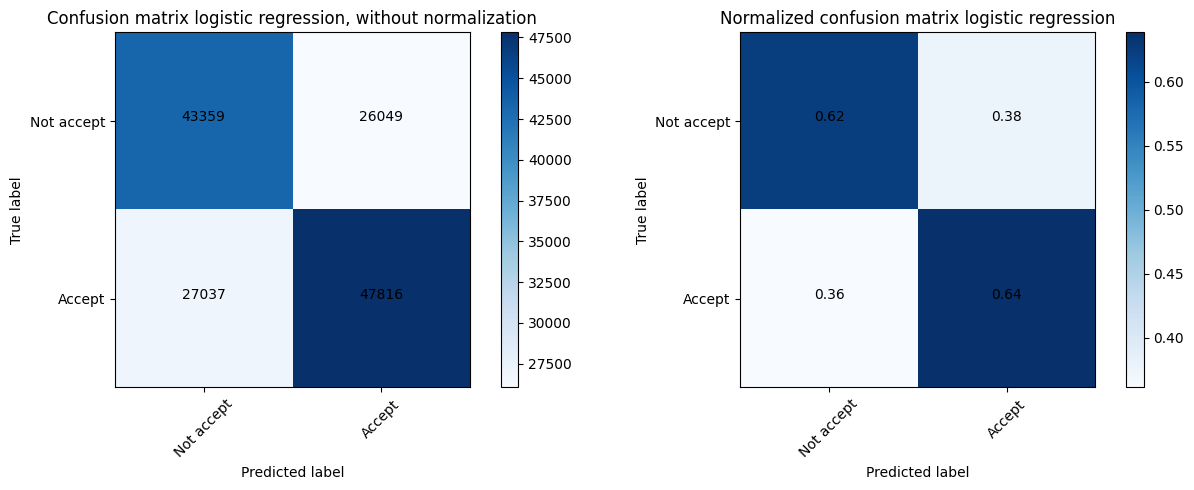

Confusion matrix, without normalization
[[29967 39441]
 [15266 59587]]
Normalized confusion matrix
[[0.43 0.57]
 [0.2  0.8 ]]


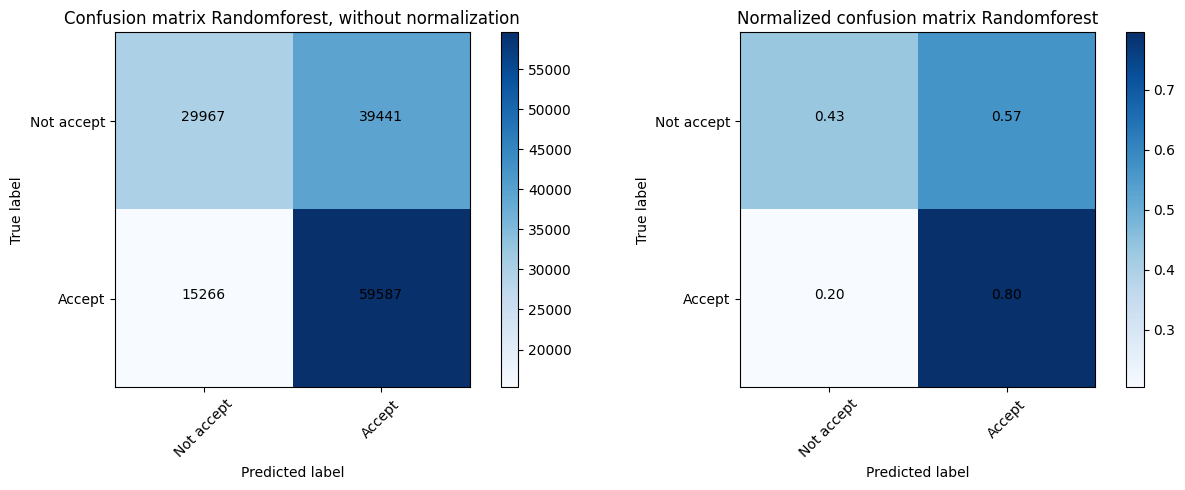

Confusion matrix, without normalization
[[41807 27601]
 [20867 53986]]
Normalized confusion matrix
[[0.6  0.4 ]
 [0.28 0.72]]


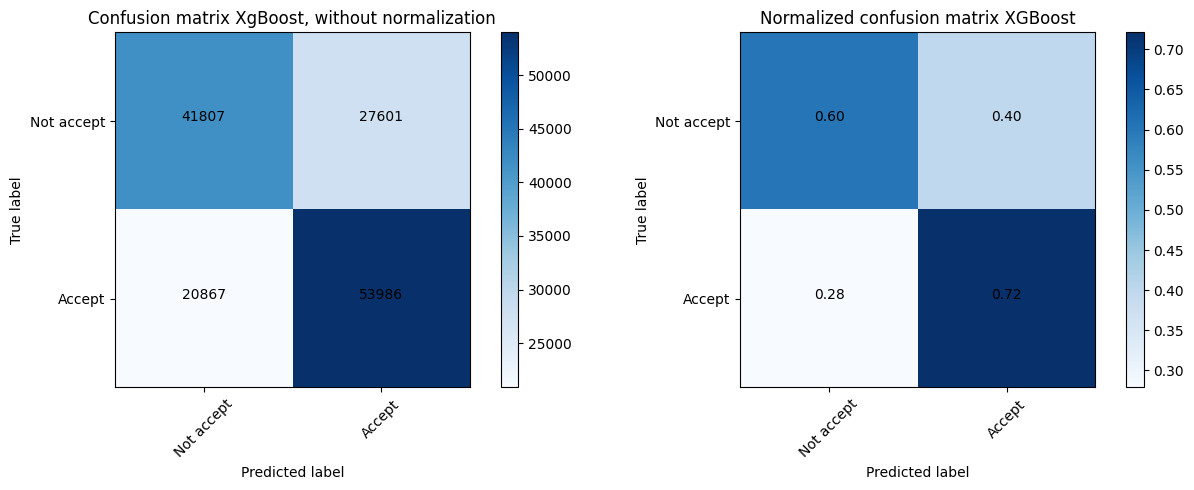

Confusion matrix, without normalization
[[42187 27221]
 [20731 54122]]
Normalized confusion matrix
[[0.61 0.39]
 [0.28 0.72]]


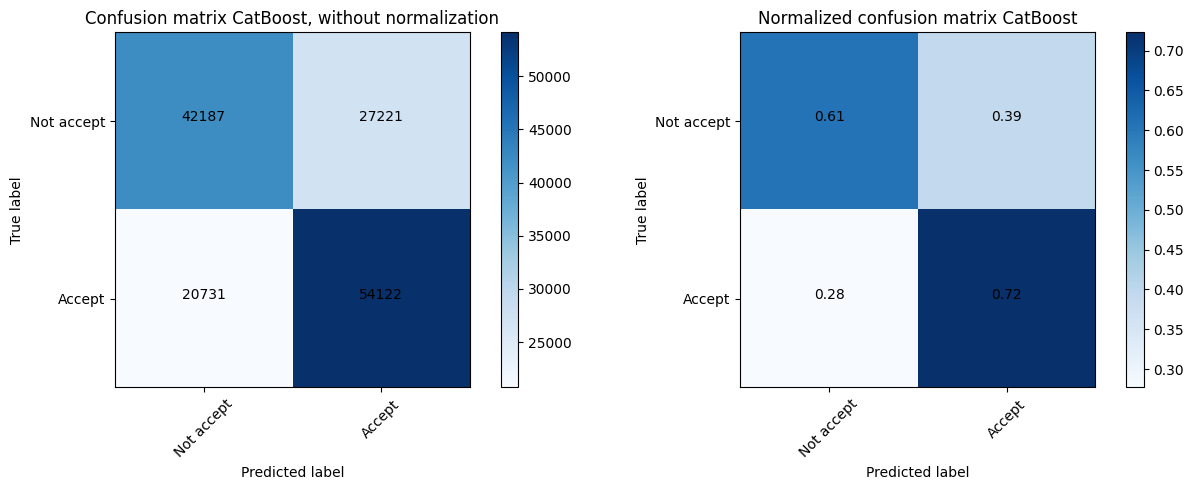

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) #added to fix a bug that causes the matrix to be squished
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names = ['Not accept', 'Accept']

# Decision tree confusion matrix
cnf_matrix_dt= confusion_matrix(y_test, y_pred_dt)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_dt, classes=class_names,
                      title='Confusion matrix decision tree, without normalization')
# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_dt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix decision tree')

plt.show()


# Logistic regression confusion matrix
cnf_matrix_lr= confusion_matrix(y_test, y_pred_lr)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_lr, classes=class_names,
                      title='Confusion matrix logistic regression, without normalization')
# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_lr, classes=class_names, normalize=True,
                      title='Normalized confusion matrix logistic regression')

plt.show()

# randomforest confusion matrix
cnf_matrix_rf= confusion_matrix(y_test, y_pred_rf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_rf, classes=class_names,
                      title='Confusion matrix Randomforest, without normalization')
# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix Randomforest')

plt.show()
    
    

# xgboost confusion matrix
cnf_matrix_xg= confusion_matrix(y_test, y_pred_xg)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_xg, classes=class_names,
                      title='Confusion matrix XgBoost, without normalization')
# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_xg, classes=class_names, normalize=True,
                      title='Normalized confusion matrix XGBoost')

plt.show()

# catboost confusion matrix
cnf_matrix_cat= confusion_matrix(y_test, y_pred_cat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_cat, classes=class_names,
                      title='Confusion matrix CatBoost, without normalization')
# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_cat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix CatBoost')

plt.show()
    
    

### b) AUC and ROC

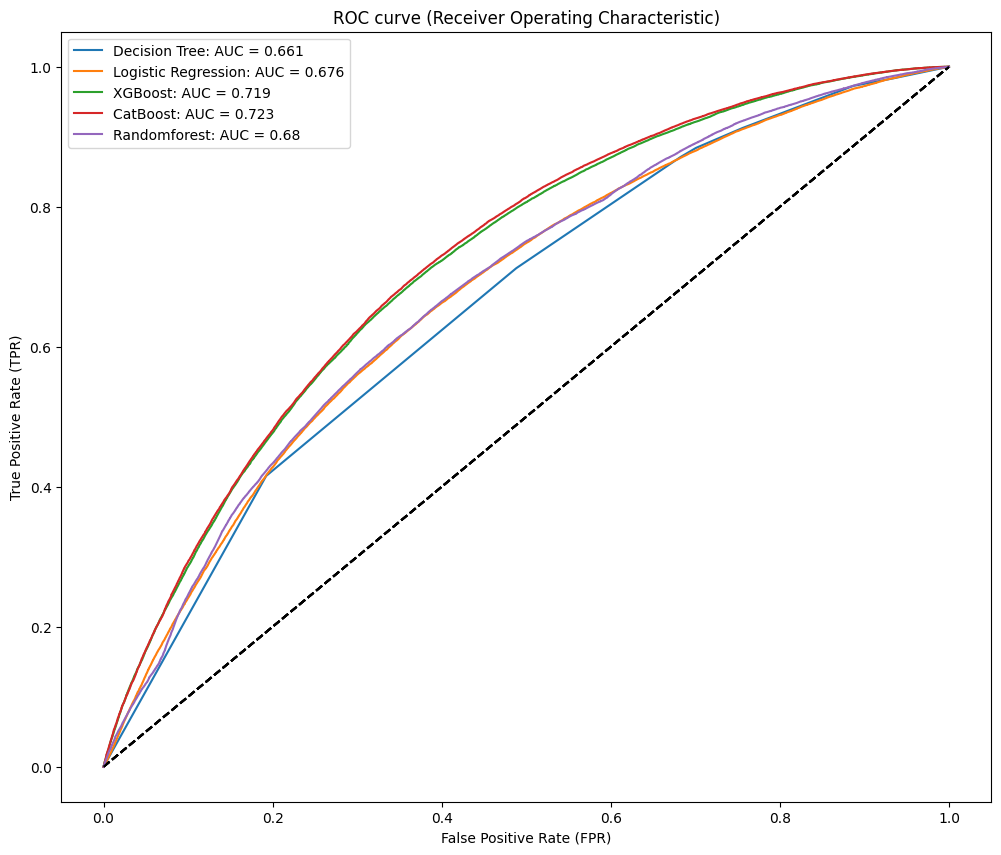

In [ ]:
plt.figure(figsize=(12,10))

for test, pred, name in zip([y_test,y_test, y_test,y_test,y_test], [y_pred_proba_dt[:,1], y_pred_proba_lr[:,1], y_pred_proba_xg[:,1], y_pred_proba_cat[:,1],y_pred_proba_rf[:,1]], ['Decision Tree', 'Logistic Regression','XGBoost', 'CatBoost','Randomforest']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

### e) Tuning Parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
#create the grid for models
grid_rf = {'max_depth': [3,4,5],'n_estimators':[100, 200, 300]}

#Instantiate GridSearchCV
gscv = GridSearchCV (estimator = rf, param_grid = grid_rf, scoring ='recall', cv = 5)

#fit the model
gscv.fit(X_train,y_train)

#returns the estimator with the best performance
print(gscv.best_estimator_)

#returns the best score
print(gscv.best_score_)

#returns the best parameters
print(gscv.best_params_)

RandomForestClassifier(max_depth=3, n_estimators=300, random_state=100)
0.7974290348074976
{'max_depth': 3, 'n_estimators': 300}


In [ ]:
# RandomForest accuracy
rf = RandomForestClassifier(max_depth = 3, n_estimators=300)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

#Probabilities for Random Forest
y_pred_proba_rf = rf.predict_proba(X_test)

print ("Accuracy is: ", (accuracy_score(y_test, y_pred_rf)*100).round(2))

Accuracy is:  62.33


Confusion matrix, without normalization
[[30355 39053]
 [15295 59558]]
Normalized confusion matrix
[[0.44 0.56]
 [0.2  0.8 ]]


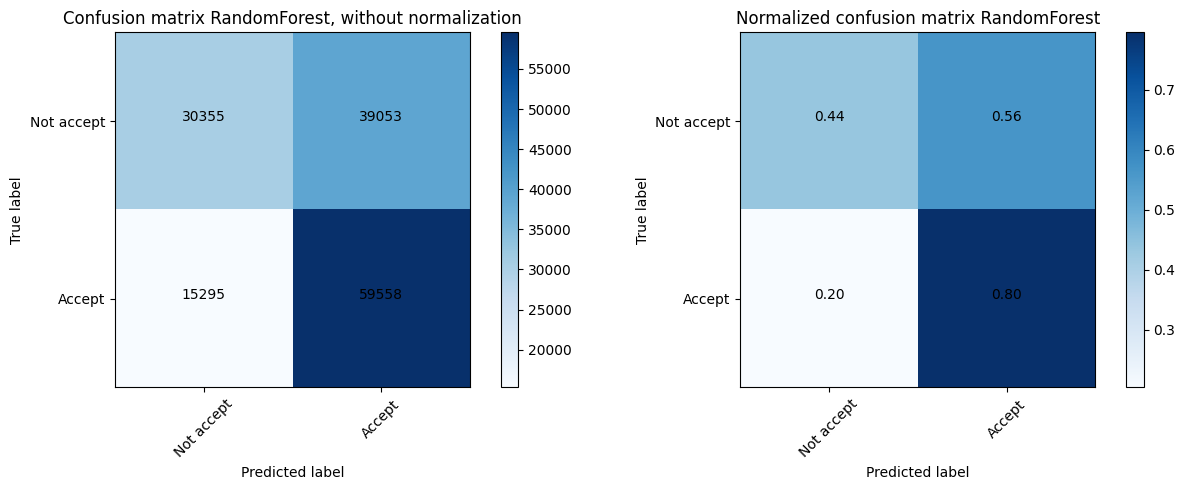

In [ ]:
# RndomForest confusion matrix
cnf_matrix_rf= confusion_matrix(y_test, y_pred_rf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_rf, classes=class_names,
                      title='Confusion matrix RandomForest, without normalization')
# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix RandomForest')

plt.show()
    

Text(0.5, 1.0, 'Feature Importance')

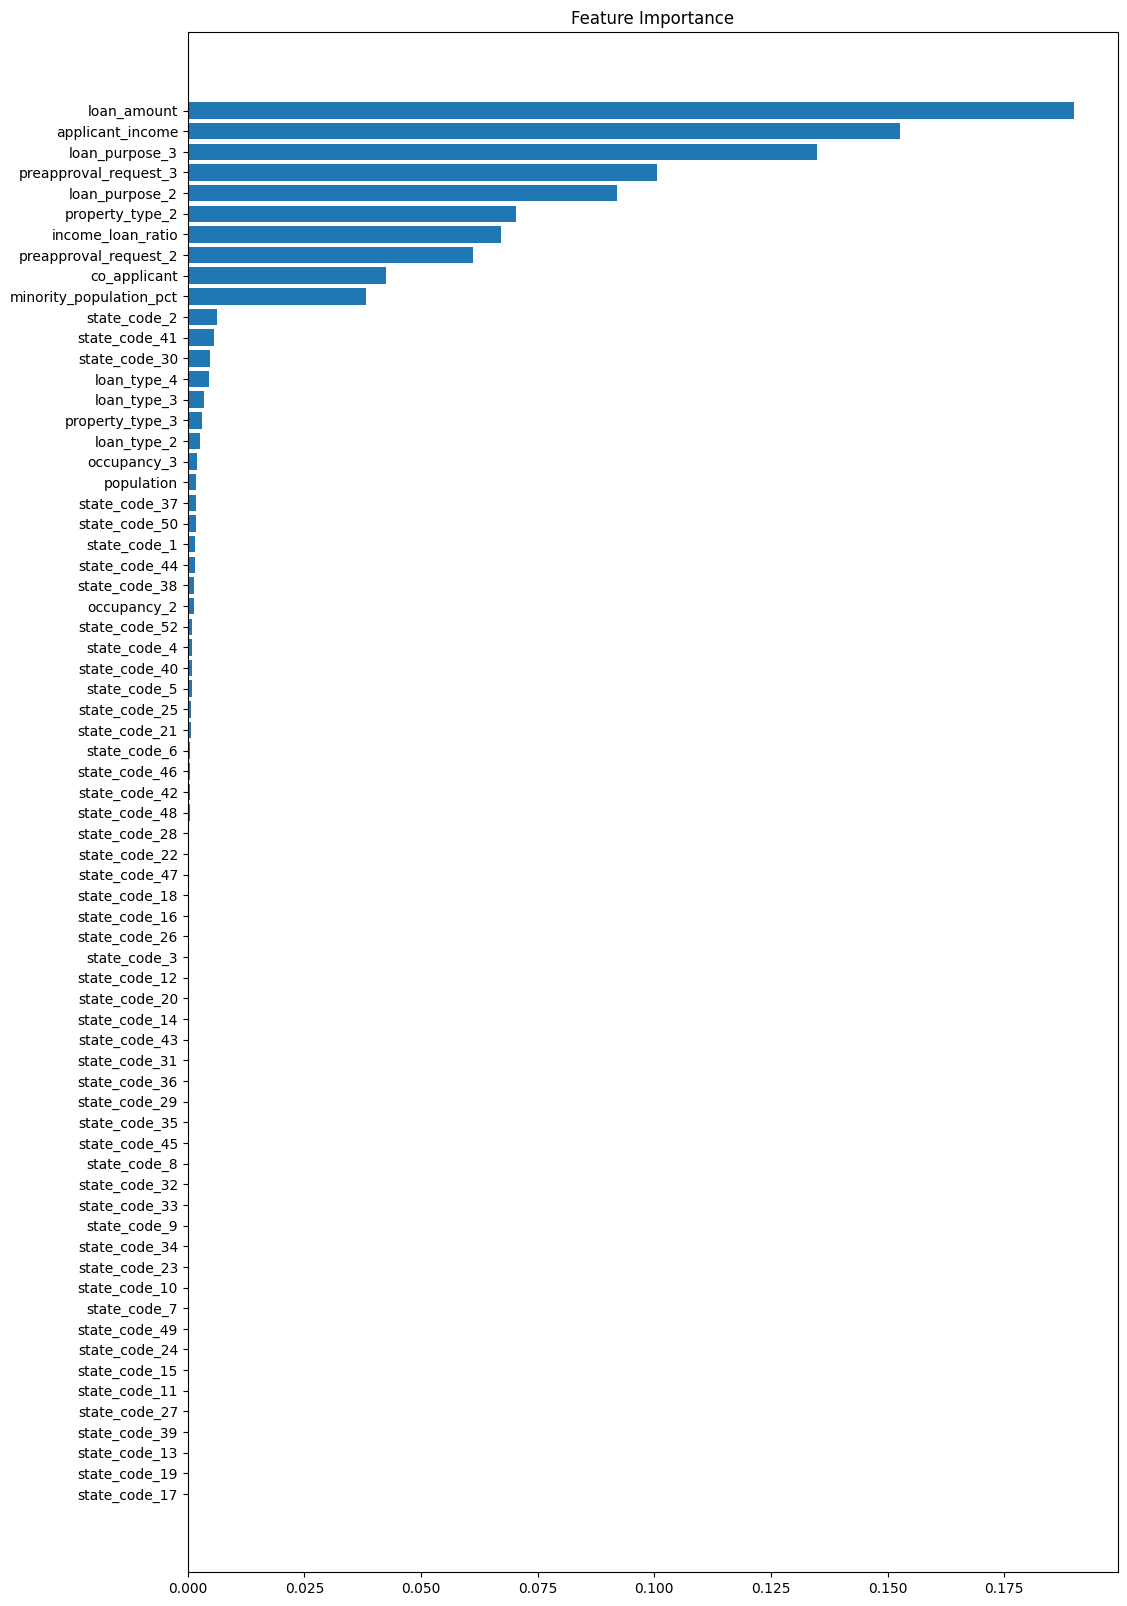

In [ ]:
feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

### d) Cross validation 

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from numpy import mean

In [ ]:
print(cross_val_score(rf, X, y, cv=10, scoring='recall').mean())


[0.81 0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.79]


In [ ]:
print(cross_val_score(rf, X, y, cv=10, scoring='accuracy').mean())

[0.62 0.62 0.62 0.62 0.62 0.62 0.62 0.63 0.62 0.62]
